In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')
import pickle
from tqdm import tqdm
import copy

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False
print(cuda, device)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

%cd drive/MyDrive/ime_project/
!ls

True cuda:0
/content/drive/MyDrive/ime_project
capston_EDA.ipynb  done		   EDA_1030.ipynb  feature_selection2.ipynb  trial.ipynb
checkpoint.pt	   EDA_1003.ipynb  EDA_1101.ipynb  feature_selection.ipynb   var.ipynb
data		   EDA_1010.ipynb  EDA_1102.ipynb  lightning_logs
DL		   EDA_1019.ipynb  EDA_1201.ipynb  result


# preprocess

In [4]:
with open('result/final_selection.pkl', 'rb') as file:
    final_selection = pickle.load(file)

In [5]:
features = []
for i in final_selection.keys():
    # print(i)
    for j in final_selection[i]:
        if j not in features:
            features.append(j)
            # print(features)
        else: pass

# features.append('cdate')

In [6]:
target = ['plant2_temperature','plant3_temperature','plant4_temperature','plant5_temperature','plant6_temperature','plant7_temperature','plant8_temperature','plant9_temperature','plant10_temperature']

In [7]:
# 앞선 feature selection으로 선택한 feature들로만 이루어진 training dataset
df_train = pd.read_csv("result/dataset.csv")#, index_col="Unnamed: 0")
df_train.rename(columns={'Unnamed: 0':'cdate'},inplace=True)

df_train["cdate"] = pd.to_datetime(df_train["cdate"])
min_date = df_train["cdate"].min()
df_train['time_idx'] = df_train["cdate"].apply(lambda x: (x - min_date).total_seconds()/60/10) # 10분단위로 timestamp
df_train['time_idx'] = df_train['time_idx'].astype(int)

df_train.set_index("cdate", inplace=True)
df_train = df_train[features]

df_train.columns = df_train.columns.str.lower()
df_train['onoff'] = df_train.loc[:, 'ahu1_inv':'ahu10_inv'].apply(lambda row: 1 if any(row != 0) else 0, axis=1)

df_train.drop("plant1_temperature", axis=1, inplace=True)

# 각 온도 열에 대해 결측값 표시 변수 추가
for col in df_train.columns:
    missing_col_name = col + "_missing"
    df_train[missing_col_name] = df_train[col].isna().astype(int)

    # 결측값을 평균값으로 채우기
    df_train[col].fillna(df_train[col].mean(), inplace=True)
    df_train.drop(missing_col_name, inplace=True, axis=1)

print(df_train.isna().any().any())
print(len(df_train.columns))
df_train = df_train.loc[:"2023-07-31 23:00:00"]
df_train.tail(1)

False
27


ahu1_inv  ahu2_inv  ahu3_inv  ahu4_inv  ahu5_inv  \
cdate                                                                   
2023-07-31 23:00:00       0.0       0.0       0.0       0.0       0.0   

                     ahu7_inv  ahu8_inv  ahu9_inv  ahu10_inv  ahu11_inv  ...  \
cdate                                                                    ...   
2023-07-31 23:00:00       0.0       0.0       0.0        0.0        0.0  ...   

                     plant5_temperature  plant6_temperature  \
cdate                                                         
2023-07-31 23:00:00               27.87               27.89   

                     plant7_temperature  plant7_humidity  plant8_temperature  \
cdate                                                                          
2023-07-31 23:00:00               28.05            41.15               28.87   

                     plant10_temperature  ahu13_inv  plant4_humidity  \
cdate                                                                  
2023-07-31 23:00:00                30.84        0.0            41.48   

                     plant9_temperature  onoff  
cdate                                           
2023-07-31 23:00:00               30.67      0  

[1 rows x 27 columns]

In [8]:
df_test = pd.read_csv("result/test.csv", index_col="cdate")
df_test.index = pd.to_datetime(df_test.index)

features.remove('Plant1_temperature')
features_low = [i.lower() for i in features]
df_test = df_test[features_low]

df_test.columns = df_test.columns.str.lower()
df_test['onoff'] = df_test.loc[:, 'ahu1_inv':'ahu10_inv'].apply(lambda row: 1 if any(row != 0) else 0, axis=1)

# 각 온도 열에 대해 결측값 표시 변수 추가
for col in df_test.columns:
    missing_col_name = col + "_missing"
    df_test[missing_col_name] = df_test[col].isna().astype(int)

    # 결측값을 평균값으로 채우기
    df_test[col].fillna(df_test[col].mean(), inplace=True)
    df_test.drop(missing_col_name, inplace=True, axis=1)

print(df_train.isna().any().any())
print(len(df_test.columns))

df_test.head(1)

False
27


ahu1_inv  ahu2_inv  ahu3_inv  ahu4_inv  ahu5_inv  ahu7_inv  \
cdate                                                                    
2023-08-01         0         0         0         0         0         0   

            ahu8_inv  ahu9_inv  ahu10_inv  ahu11_inv  ...  plant5_temperature  \
cdate                                                 ...                       
2023-08-01         0         0          0          0  ...               27.85   

            plant6_temperature  plant7_temperature  plant7_humidity  \
cdate                                                                 
2023-08-01               27.85               27.98            41.65   

            plant8_temperature  plant10_temperature  ahu13_inv  \
cdate                                                            
2023-08-01               28.85                30.68          0   

            plant4_humidity  plant9_temperature  onoff  
cdate                                                   
2023-08-01            41.87               30.61      0  

[1 rows x 27 columns]

In [9]:
y = df_train.loc[:,target]
X = df_train.drop(columns=target)

In [10]:
y.head(2)

plant2_temperature  plant3_temperature  \
cdate                                                         
2023-01-01 08:00:00               26.15               26.16   
2023-01-01 08:10:00               26.23               26.20   

                     plant4_temperature  plant5_temperature  \
cdate                                                         
2023-01-01 08:00:00               25.83               25.84   
2023-01-01 08:10:00               25.93               25.88   

                     plant6_temperature  plant7_temperature  \
cdate                                                         
2023-01-01 08:00:00               25.83                25.7   
2023-01-01 08:10:00               25.95                25.7   

                     plant8_temperature  plant9_temperature  \
cdate                                                         
2023-01-01 08:00:00               26.31               23.09   
2023-01-01 08:10:00               26.38               23.49   

                     plant10_temperature  
cdate                                     
2023-01-01 08:00:00                23.36  
2023-01-01 08:10:00                23.73

In [11]:
X.head(2)

ahu1_inv  ahu2_inv  ahu3_inv   ahu4_inv   ahu5_inv  \
cdate                                                                     
2023-01-01 08:00:00      35.0  18.90246      35.0  19.266979  18.445291   
2023-01-01 08:10:00      35.0  18.90246      35.0  19.266979  18.445291   

                      ahu7_inv   ahu8_inv   ahu9_inv  ahu10_inv  ahu11_inv  \
cdate                                                                        
2023-01-01 08:00:00  18.043542  20.834108  19.026433  19.656569  19.619934   
2023-01-01 08:10:00  18.043542  20.834108  19.026433  19.656569  19.619934   

                     ahu12_inv  ahu14_inv  plant2_humidity  plant3_humidity  \
cdate                                                                         
2023-01-01 08:00:00  20.200386  20.810474            38.95            38.78   
2023-01-01 08:10:00  20.200386  20.810474            39.01            39.07   

                     plant7_humidity  ahu13_inv  plant4_humidity  onoff  
cdate                                                                    
2023-01-01 08:00:00            40.07  19.713945            39.42      1  
2023-01-01 08:10:00            41.96  19.713945            39.62      1

# trainning

In [12]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

len_train = int(len(df_train)*0.8) # training 80% , validation 20%

X_train = X_ss[:len_train, :]
X_test = X_ss[len_train:, :]

y_train = y_ms[:len_train, :]
y_test = y_ms[len_train:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (24380, 18) (24380, 9)
Testing Shape (6095, 18) (6095, 9)


In [13]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([24380, 1, 18]) torch.Size([24380, 9])
Testing Shape torch.Size([6095, 1, 18]) torch.Size([6095, 9])


In [14]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)

        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.dropout(out)
        out = self.relu(out)
        # out = out[:,-1,:]
        out = self.fc(out)
        return out

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [15]:
num_epochs = 1000000
learning_rate = 1e-6

input_size = X_train_tensors_f.size(-1)

early_stopping = EarlyStopping(patience=10000, verbose=False) # 모델이 더 이상 성능이 향상되지 않을 때 학습을 조기에 중단하는 기법

hidden_size = 32
num_layers = 1
num_classes = y_train_tensors.shape[1]

model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])
model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 1e-8) # weight decay는 모델의 복잡성을 줄이고 과적합 방지하는 정규화 기법
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1) # schedular는 학습 과정 중 learning rate 조정하여 wegiht 조정하여 성능 개선하는 기

In [ ]:
loss_list = []
for epoch in tqdm(range(num_epochs)):
    model.train() # 학습모드

    X_train_tensors_f = X_train_tensors_f.to(device)
    y_train_tensors = y_train_tensors.to(device)

    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)

    early_stopping(loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    loss_list.append(loss.item())
    loss.backward()
    optimizer.step()
    # scheduler.step()

    if epoch % 1000 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

model.load_state_dict(torch.load('checkpoint.pt'))


  0%|          | 14/1000000 [00:00<4:20:19, 64.02it/s]

Epoch: 0, loss: 0.32243


  0%|          | 1027/1000000 [00:10<2:06:48, 131.30it/s]

Epoch: 1000, loss: 0.31375


  0%|          | 2015/1000000 [00:17<1:57:14, 141.86it/s]

Epoch: 2000, loss: 0.30516


  0%|          | 3017/1000000 [00:24<2:00:12, 138.22it/s]

Epoch: 3000, loss: 0.29664


  0%|          | 4025/1000000 [00:32<1:59:24, 139.02it/s]

Epoch: 4000, loss: 0.28790


  1%|          | 5027/1000000 [00:38<1:46:12, 156.14it/s]

Epoch: 5000, loss: 0.27913


  1%|          | 6021/1000000 [00:46<1:53:16, 146.25it/s]

Epoch: 6000, loss: 0.27004


  1%|          | 7020/1000000 [00:52<1:49:56, 150.52it/s]

Epoch: 7000, loss: 0.26094


  1%|          | 8025/1000000 [00:59<1:59:36, 138.23it/s]

Epoch: 8000, loss: 0.25169


  1%|          | 9030/1000000 [01:06<1:45:30, 156.55it/s]

Epoch: 9000, loss: 0.24224


  1%|          | 10026/1000000 [01:13<2:04:09, 132.90it/s]

Epoch: 10000, loss: 0.23260


  1%|          | 11016/1000000 [01:20<1:48:14, 152.27it/s]

Epoch: 11000, loss: 0.22293


  1%|          | 12021/1000000 [01:27<2:04:16, 132.51it/s]

Epoch: 12000, loss: 0.21283


  1%|▏         | 13019/1000000 [01:33<1:44:49, 156.93it/s]

Epoch: 13000, loss: 0.20270


  1%|▏         | 14023/1000000 [01:40<2:12:01, 124.47it/s]

Epoch: 14000, loss: 0.19240


  2%|▏         | 15030/1000000 [01:47<1:41:51, 161.16it/s]

Epoch: 15000, loss: 0.18174


  2%|▏         | 16022/1000000 [01:54<2:02:59, 133.33it/s]

Epoch: 16000, loss: 0.17109


  2%|▏         | 17029/1000000 [02:01<1:44:40, 156.50it/s]

Epoch: 17000, loss: 0.16032


  2%|▏         | 18021/1000000 [02:07<1:46:50, 153.18it/s]

Epoch: 18000, loss: 0.14947


  2%|▏         | 19030/1000000 [02:15<1:42:07, 160.08it/s]

Epoch: 19000, loss: 0.13855


  2%|▏         | 20027/1000000 [02:21<1:45:15, 155.17it/s]

Epoch: 20000, loss: 0.12769


  2%|▏         | 21030/1000000 [02:28<1:56:41, 139.82it/s]

Epoch: 21000, loss: 0.11688


  2%|▏         | 22020/1000000 [02:34<1:48:44, 149.89it/s]

Epoch: 22000, loss: 0.10641


  2%|▏         | 23018/1000000 [02:41<1:48:06, 150.61it/s]

Epoch: 23000, loss: 0.09609


  2%|▏         | 24031/1000000 [02:48<1:44:01, 156.36it/s]

Epoch: 24000, loss: 0.08619


  3%|▎         | 25029/1000000 [02:55<1:54:25, 142.01it/s]

Epoch: 25000, loss: 0.07683


  3%|▎         | 26031/1000000 [03:01<1:44:02, 156.03it/s]

Epoch: 26000, loss: 0.06809


  3%|▎         | 27018/1000000 [03:08<1:51:21, 145.62it/s]

Epoch: 27000, loss: 0.06000


  3%|▎         | 28023/1000000 [03:14<1:42:26, 158.14it/s]

Epoch: 28000, loss: 0.05283


  3%|▎         | 29031/1000000 [03:20<1:41:08, 160.01it/s]

Epoch: 29000, loss: 0.04667


  3%|▎         | 30032/1000000 [03:27<1:41:59, 158.51it/s]

Epoch: 30000, loss: 0.04153


  3%|▎         | 31030/1000000 [03:33<1:31:35, 176.33it/s]

Epoch: 31000, loss: 0.03729


  3%|▎         | 32033/1000000 [03:39<1:42:36, 157.24it/s]

Epoch: 32000, loss: 0.03418


  3%|▎         | 33027/1000000 [03:45<1:30:30, 178.08it/s]

Epoch: 33000, loss: 0.03172


  3%|▎         | 34032/1000000 [03:51<1:29:00, 180.86it/s]

Epoch: 34000, loss: 0.02955


  4%|▎         | 35022/1000000 [03:57<1:33:31, 171.96it/s]

Epoch: 35000, loss: 0.02818


  4%|▎         | 36031/1000000 [04:02<1:31:20, 175.89it/s]

Epoch: 36000, loss: 0.02690


  4%|▎         | 37032/1000000 [04:08<1:42:27, 156.64it/s]

Epoch: 37000, loss: 0.02575


  4%|▍         | 38037/1000000 [04:14<1:25:54, 186.63it/s]

Epoch: 38000, loss: 0.02486


  4%|▍         | 39033/1000000 [04:19<1:23:56, 190.79it/s]

Epoch: 39000, loss: 0.02420


  4%|▍         | 40023/1000000 [04:25<1:39:55, 160.11it/s]

Epoch: 40000, loss: 0.02346


  4%|▍         | 41028/1000000 [04:30<1:22:49, 192.96it/s]

Epoch: 41000, loss: 0.02309


  4%|▍         | 42033/1000000 [04:36<1:30:13, 176.94it/s]

Epoch: 42000, loss: 0.02254


  4%|▍         | 43022/1000000 [04:42<1:27:50, 181.57it/s]

Epoch: 43000, loss: 0.02207


  4%|▍         | 44025/1000000 [04:47<1:26:14, 184.76it/s]

Epoch: 44000, loss: 0.02176


  5%|▍         | 45036/1000000 [04:53<1:33:47, 169.70it/s]

Epoch: 45000, loss: 0.02144


  5%|▍         | 46030/1000000 [04:58<1:22:39, 192.34it/s]

Epoch: 46000, loss: 0.02102


  5%|▍         | 47038/1000000 [05:04<1:26:03, 184.55it/s]

Epoch: 47000, loss: 0.02069


  5%|▍         | 48026/1000000 [05:09<1:40:08, 158.44it/s]

Epoch: 48000, loss: 0.02051


  5%|▍         | 49026/1000000 [05:15<1:29:10, 177.73it/s]

Epoch: 49000, loss: 0.02020


  5%|▌         | 50023/1000000 [05:20<1:30:59, 174.00it/s]

Epoch: 50000, loss: 0.02001


  5%|▌         | 51019/1000000 [05:26<1:21:04, 195.10it/s]

Epoch: 51000, loss: 0.01982


  5%|▌         | 52038/1000000 [05:31<1:26:32, 182.55it/s]

Epoch: 52000, loss: 0.01958


  5%|▌         | 53025/1000000 [05:37<1:35:17, 165.64it/s]

Epoch: 53000, loss: 0.01936


  5%|▌         | 54040/1000000 [05:42<1:22:11, 191.81it/s]

Epoch: 54000, loss: 0.01927


  6%|▌         | 55038/1000000 [05:47<1:22:07, 191.76it/s]

Epoch: 55000, loss: 0.01910


  6%|▌         | 56034/1000000 [05:53<1:32:43, 169.67it/s]

Epoch: 56000, loss: 0.01881


  6%|▌         | 57025/1000000 [05:58<1:22:19, 190.90it/s]

Epoch: 57000, loss: 0.01878


  6%|▌         | 58039/1000000 [06:04<1:23:03, 189.03it/s]

Epoch: 58000, loss: 0.01848


  6%|▌         | 59027/1000000 [06:10<1:22:43, 189.58it/s]

Epoch: 59000, loss: 0.01835


  6%|▌         | 60023/1000000 [06:15<1:21:44, 191.67it/s]

Epoch: 60000, loss: 0.01818


  6%|▌         | 61030/1000000 [06:20<1:28:53, 176.06it/s]

Epoch: 61000, loss: 0.01810


  6%|▌         | 62032/1000000 [06:26<1:20:11, 194.95it/s]

Epoch: 62000, loss: 0.01801


  6%|▋         | 63038/1000000 [06:31<1:22:32, 189.19it/s]

Epoch: 63000, loss: 0.01786


  6%|▋         | 64019/1000000 [06:37<1:31:29, 170.50it/s]

Epoch: 64000, loss: 0.01778


  7%|▋         | 65036/1000000 [06:42<1:21:41, 190.74it/s]

Epoch: 65000, loss: 0.01765


  7%|▋         | 66031/1000000 [06:47<1:20:35, 193.13it/s]

Epoch: 66000, loss: 0.01756


  7%|▋         | 67021/1000000 [06:53<1:32:11, 168.67it/s]

Epoch: 67000, loss: 0.01745


  7%|▋         | 68034/1000000 [06:58<1:21:27, 190.67it/s]

Epoch: 68000, loss: 0.01741


  7%|▋         | 69031/1000000 [07:04<1:28:11, 175.95it/s]

Epoch: 69000, loss: 0.01722


  7%|▋         | 70025/1000000 [07:10<1:22:49, 187.13it/s]

Epoch: 70000, loss: 0.01720


  7%|▋         | 71022/1000000 [07:15<1:20:41, 191.87it/s]

Epoch: 71000, loss: 0.01707


  7%|▋         | 72023/1000000 [07:20<1:37:02, 159.38it/s]

Epoch: 72000, loss: 0.01690


  7%|▋         | 73024/1000000 [07:26<1:18:15, 197.41it/s]

Epoch: 73000, loss: 0.01697


  7%|▋         | 74024/1000000 [07:31<1:20:55, 190.72it/s]

Epoch: 74000, loss: 0.01683


  8%|▊         | 75026/1000000 [07:37<1:30:59, 169.42it/s]

Epoch: 75000, loss: 0.01675


  8%|▊         | 76034/1000000 [07:42<1:19:28, 193.77it/s]

Epoch: 76000, loss: 0.01677


  8%|▊         | 77037/1000000 [07:47<1:20:16, 191.64it/s]

Epoch: 77000, loss: 0.01665


  8%|▊         | 78026/1000000 [07:53<1:25:27, 179.82it/s]

Epoch: 78000, loss: 0.01663


  8%|▊         | 79034/1000000 [07:58<1:18:23, 195.79it/s]

Epoch: 79000, loss: 0.01654


  8%|▊         | 80029/1000000 [08:03<1:26:06, 178.06it/s]

Epoch: 80000, loss: 0.01643


  8%|▊         | 81033/1000000 [08:09<1:22:54, 184.75it/s]

Epoch: 81000, loss: 0.01642


  8%|▊         | 82026/1000000 [08:14<1:17:53, 196.43it/s]

Epoch: 82000, loss: 0.01636


  8%|▊         | 83018/1000000 [08:20<1:29:47, 170.21it/s]

Epoch: 83000, loss: 0.01635


  8%|▊         | 84038/1000000 [08:25<1:22:14, 185.62it/s]

Epoch: 84000, loss: 0.01624


  9%|▊         | 85022/1000000 [08:30<1:19:18, 192.29it/s]

Epoch: 85000, loss: 0.01629


  9%|▊         | 86027/1000000 [08:36<1:32:21, 164.94it/s]

Epoch: 86000, loss: 0.01614


  9%|▊         | 87028/1000000 [08:42<1:19:31, 191.34it/s]

Epoch: 87000, loss: 0.01613


  9%|▉         | 88029/1000000 [08:47<1:20:54, 187.86it/s]

Epoch: 88000, loss: 0.01600


  9%|▉         | 89033/1000000 [08:53<1:25:30, 177.55it/s]

Epoch: 89000, loss: 0.01605


  9%|▉         | 90027/1000000 [08:58<1:19:23, 191.05it/s]

Epoch: 90000, loss: 0.01595


  9%|▉         | 91023/1000000 [09:03<1:29:57, 168.40it/s]

Epoch: 91000, loss: 0.01594


  9%|▉         | 92026/1000000 [09:09<1:18:42, 192.27it/s]

Epoch: 92000, loss: 0.01581


  9%|▉         | 93029/1000000 [09:14<1:28:58, 169.88it/s]

Epoch: 93000, loss: 0.01577


  9%|▉         | 94029/1000000 [09:20<1:31:25, 165.16it/s]

Epoch: 94000, loss: 0.01584


 10%|▉         | 95028/1000000 [09:26<1:18:03, 193.24it/s]

Epoch: 95000, loss: 0.01575


 10%|▉         | 96029/1000000 [09:31<1:18:39, 191.54it/s]

Epoch: 96000, loss: 0.01566


 10%|▉         | 97028/1000000 [09:37<1:30:34, 166.15it/s]

Epoch: 97000, loss: 0.01567


 10%|▉         | 98024/1000000 [09:42<1:18:33, 191.36it/s]

Epoch: 98000, loss: 0.01559


 10%|▉         | 99030/1000000 [09:48<1:18:43, 190.76it/s]

Epoch: 99000, loss: 0.01559


 10%|█         | 100032/1000000 [09:53<1:22:15, 182.36it/s]

Epoch: 100000, loss: 0.01549


 10%|█         | 101025/1000000 [09:59<1:18:09, 191.68it/s]

Epoch: 101000, loss: 0.01544


 10%|█         | 102031/1000000 [10:04<1:27:05, 171.85it/s]

Epoch: 102000, loss: 0.01537


 10%|█         | 103024/1000000 [10:10<1:16:05, 196.48it/s]

Epoch: 103000, loss: 0.01535


 10%|█         | 104025/1000000 [10:15<1:17:18, 193.17it/s]

Epoch: 104000, loss: 0.01526


 11%|█         | 105028/1000000 [10:20<1:29:40, 166.35it/s]

Epoch: 105000, loss: 0.01519


 11%|█         | 106036/1000000 [10:26<1:17:31, 192.20it/s]

Epoch: 106000, loss: 0.01517


 11%|█         | 107020/1000000 [10:31<1:17:41, 191.55it/s]

Epoch: 107000, loss: 0.01514


 11%|█         | 108023/1000000 [10:37<1:27:32, 169.81it/s]

Epoch: 108000, loss: 0.01505


 11%|█         | 109030/1000000 [10:42<1:14:30, 199.28it/s]

Epoch: 109000, loss: 0.01498


 11%|█         | 110030/1000000 [10:47<1:15:06, 197.50it/s]

Epoch: 110000, loss: 0.01494


 11%|█         | 111040/1000000 [10:53<1:18:04, 189.75it/s]

Epoch: 111000, loss: 0.01491


 11%|█         | 112038/1000000 [10:58<1:17:08, 191.83it/s]

Epoch: 112000, loss: 0.01483


 11%|█▏        | 113027/1000000 [11:03<1:25:59, 171.90it/s]

Epoch: 113000, loss: 0.01474


 11%|█▏        | 114024/1000000 [11:09<1:19:40, 185.33it/s]

Epoch: 114000, loss: 0.01478


 12%|█▏        | 115034/1000000 [11:14<1:15:51, 194.42it/s]

Epoch: 115000, loss: 0.01478


 12%|█▏        | 116027/1000000 [11:19<1:26:53, 169.54it/s]

Epoch: 116000, loss: 0.01464


 12%|█▏        | 117021/1000000 [11:25<1:14:31, 197.46it/s]

Epoch: 117000, loss: 0.01456


 12%|█▏        | 118034/1000000 [11:30<1:15:44, 194.09it/s]

Epoch: 118000, loss: 0.01449


 12%|█▏        | 119035/1000000 [11:35<1:24:08, 174.50it/s]

Epoch: 119000, loss: 0.01446


 12%|█▏        | 120021/1000000 [11:41<1:14:35, 196.63it/s]

Epoch: 120000, loss: 0.01441


 12%|█▏        | 121037/1000000 [11:46<1:17:32, 188.92it/s]

Epoch: 121000, loss: 0.01438


 12%|█▏        | 122015/1000000 [11:51<1:30:44, 161.25it/s]

Epoch: 122000, loss: 0.01436


 12%|█▏        | 123036/1000000 [11:57<1:15:57, 192.42it/s]

Epoch: 123000, loss: 0.01421


 12%|█▏        | 124018/1000000 [12:02<1:23:35, 174.66it/s]

Epoch: 124000, loss: 0.01420


 13%|█▎        | 125029/1000000 [12:08<1:19:35, 183.23it/s]

Epoch: 125000, loss: 0.01412


 13%|█▎        | 126033/1000000 [12:13<1:15:37, 192.60it/s]

Epoch: 126000, loss: 0.01412


 13%|█▎        | 127029/1000000 [12:18<1:25:34, 170.02it/s]

Epoch: 127000, loss: 0.01404


 13%|█▎        | 128032/1000000 [12:24<1:13:00, 199.05it/s]

Epoch: 128000, loss: 0.01396


 13%|█▎        | 129022/1000000 [12:29<1:18:42, 184.44it/s]

Epoch: 129000, loss: 0.01391


 13%|█▎        | 130030/1000000 [12:35<1:22:39, 175.40it/s]

Epoch: 130000, loss: 0.01387


 13%|█▎        | 131036/1000000 [12:40<1:15:44, 191.23it/s]

Epoch: 131000, loss: 0.01377


 13%|█▎        | 132023/1000000 [12:45<1:15:23, 191.90it/s]

Epoch: 132000, loss: 0.01375


 13%|█▎        | 133029/1000000 [12:51<1:24:08, 171.72it/s]

Epoch: 133000, loss: 0.01365


 13%|█▎        | 134033/1000000 [12:56<1:13:40, 195.92it/s]

Epoch: 134000, loss: 0.01360


 14%|█▎        | 135033/1000000 [13:01<1:19:23, 181.60it/s]

Epoch: 135000, loss: 0.01360


 14%|█▎        | 136023/1000000 [13:07<1:13:14, 196.62it/s]

Epoch: 136000, loss: 0.01353


 14%|█▎        | 137037/1000000 [13:12<1:14:21, 193.42it/s]

Epoch: 137000, loss: 0.01349


 14%|█▍        | 138021/1000000 [13:17<1:24:58, 169.06it/s]

Epoch: 138000, loss: 0.01343


 14%|█▍        | 139031/1000000 [13:23<1:15:01, 191.24it/s]

Epoch: 139000, loss: 0.01338


 14%|█▍        | 140037/1000000 [13:28<1:11:56, 199.24it/s]

Epoch: 140000, loss: 0.01333


 14%|█▍        | 141034/1000000 [13:33<1:21:56, 174.71it/s]

Epoch: 141000, loss: 0.01327


 14%|█▍        | 142025/1000000 [13:39<1:10:54, 201.68it/s]

Epoch: 142000, loss: 0.01319


 14%|█▍        | 143033/1000000 [13:44<1:15:02, 190.32it/s]

Epoch: 143000, loss: 0.01322


 14%|█▍        | 144026/1000000 [13:49<1:23:59, 169.84it/s]

Epoch: 144000, loss: 0.01312


 15%|█▍        | 145033/1000000 [13:55<1:13:24, 194.09it/s]

Epoch: 145000, loss: 0.01313


 15%|█▍        | 146030/1000000 [14:00<1:15:14, 189.16it/s]

Epoch: 146000, loss: 0.01314


 15%|█▍        | 147038/1000000 [14:05<1:13:17, 193.98it/s]

Epoch: 147000, loss: 0.01295


 15%|█▍        | 148029/1000000 [14:10<1:11:11, 199.44it/s]

Epoch: 148000, loss: 0.01298


 15%|█▍        | 149032/1000000 [14:16<1:19:33, 178.27it/s]

Epoch: 149000, loss: 0.01294


 15%|█▌        | 150040/1000000 [14:21<1:11:47, 197.30it/s]

Epoch: 150000, loss: 0.01286


 15%|█▌        | 151034/1000000 [14:26<1:12:49, 194.31it/s]

Epoch: 151000, loss: 0.01280


 15%|█▌        | 152031/1000000 [14:32<1:19:34, 177.62it/s]

Epoch: 152000, loss: 0.01279


 15%|█▌        | 153035/1000000 [14:37<1:11:44, 196.76it/s]

Epoch: 153000, loss: 0.01274


 15%|█▌        | 154025/1000000 [14:42<1:09:43, 202.22it/s]

Epoch: 154000, loss: 0.01271


 16%|█▌        | 155023/1000000 [14:48<1:19:03, 178.13it/s]

Epoch: 155000, loss: 0.01268


 16%|█▌        | 156029/1000000 [14:53<1:11:28, 196.81it/s]

Epoch: 156000, loss: 0.01264


 16%|█▌        | 157021/1000000 [14:58<1:11:43, 195.90it/s]

Epoch: 157000, loss: 0.01258


 16%|█▌        | 158037/1000000 [15:04<1:13:28, 190.99it/s]

Epoch: 158000, loss: 0.01255


 16%|█▌        | 159026/1000000 [15:09<1:12:37, 193.01it/s]

Epoch: 159000, loss: 0.01260


 16%|█▌        | 160018/1000000 [15:14<1:18:45, 177.74it/s]

Epoch: 160000, loss: 0.01256


 16%|█▌        | 161027/1000000 [15:19<1:09:12, 202.04it/s]

Epoch: 161000, loss: 0.01249


 16%|█▌        | 162023/1000000 [15:24<1:09:35, 200.68it/s]

Epoch: 162000, loss: 0.01245


 16%|█▋        | 163029/1000000 [15:30<1:18:50, 176.92it/s]

Epoch: 163000, loss: 0.01244


 16%|█▋        | 164031/1000000 [15:35<1:14:03, 188.12it/s]

Epoch: 164000, loss: 0.01241


 17%|█▋        | 165040/1000000 [15:40<1:11:55, 193.50it/s]

Epoch: 165000, loss: 0.01241


 17%|█▋        | 166037/1000000 [15:46<1:20:03, 173.62it/s]

Epoch: 166000, loss: 0.01233


 17%|█▋        | 167039/1000000 [15:51<1:12:01, 192.76it/s]

Epoch: 167000, loss: 0.01228


 17%|█▋        | 168038/1000000 [15:56<1:09:21, 199.92it/s]

Epoch: 168000, loss: 0.01225


 17%|█▋        | 169027/1000000 [16:02<1:20:20, 172.37it/s]

Epoch: 169000, loss: 0.01234


 17%|█▋        | 170032/1000000 [16:07<1:11:44, 192.81it/s]

Epoch: 170000, loss: 0.01223


 17%|█▋        | 171024/1000000 [16:12<1:17:44, 177.72it/s]

Epoch: 171000, loss: 0.01226


 17%|█▋        | 172031/1000000 [16:18<1:09:45, 197.84it/s]

Epoch: 172000, loss: 0.01222


 17%|█▋        | 173025/1000000 [16:23<1:11:17, 193.31it/s]

Epoch: 173000, loss: 0.01215


 17%|█▋        | 174018/1000000 [16:28<1:17:11, 178.36it/s]

Epoch: 174000, loss: 0.01217


 18%|█▊        | 175033/1000000 [16:34<1:13:20, 187.47it/s]

Epoch: 175000, loss: 0.01215


 18%|█▊        | 176040/1000000 [16:39<1:10:22, 195.15it/s]

Epoch: 176000, loss: 0.01208


 18%|█▊        | 177026/1000000 [16:45<1:22:26, 166.38it/s]

Epoch: 177000, loss: 0.01206


 18%|█▊        | 178036/1000000 [16:50<1:09:41, 196.56it/s]

Epoch: 178000, loss: 0.01201


 18%|█▊        | 179030/1000000 [16:55<1:14:08, 184.53it/s]

Epoch: 179000, loss: 0.01201


 18%|█▊        | 180018/1000000 [17:01<1:24:38, 161.45it/s]

Epoch: 180000, loss: 0.01192


 18%|█▊        | 181022/1000000 [17:06<1:11:56, 189.73it/s]

Epoch: 181000, loss: 0.01190


 18%|█▊        | 182027/1000000 [17:11<1:16:56, 177.20it/s]

Epoch: 182000, loss: 0.01192


 18%|█▊        | 183030/1000000 [17:17<1:10:03, 194.35it/s]

Epoch: 183000, loss: 0.01186


 18%|█▊        | 184037/1000000 [17:22<1:07:39, 200.99it/s]

Epoch: 184000, loss: 0.01188


 19%|█▊        | 185030/1000000 [17:27<1:22:25, 164.77it/s]

Epoch: 185000, loss: 0.01185


 19%|█▊        | 186024/1000000 [17:33<1:09:36, 194.88it/s]

Epoch: 186000, loss: 0.01179


 19%|█▊        | 187031/1000000 [17:38<1:09:45, 194.22it/s]

Epoch: 187000, loss: 0.01177


 19%|█▉        | 188020/1000000 [17:43<1:19:21, 170.54it/s]

Epoch: 188000, loss: 0.01173


 19%|█▉        | 189018/1000000 [17:49<1:15:15, 179.59it/s]

Epoch: 189000, loss: 0.01171


 19%|█▉        | 190034/1000000 [17:54<1:08:33, 196.90it/s]

Epoch: 190000, loss: 0.01169


 19%|█▉        | 191032/1000000 [18:00<1:22:24, 163.61it/s]

Epoch: 191000, loss: 0.01165


 19%|█▉        | 192038/1000000 [18:05<1:07:25, 199.72it/s]

Epoch: 192000, loss: 0.01166


 19%|█▉        | 193034/1000000 [18:10<1:16:07, 176.69it/s]

Epoch: 193000, loss: 0.01159


 19%|█▉        | 194025/1000000 [18:16<1:11:02, 189.10it/s]

Epoch: 194000, loss: 0.01165


 20%|█▉        | 195021/1000000 [18:21<1:08:51, 194.82it/s]

Epoch: 195000, loss: 0.01163


 20%|█▉        | 196030/1000000 [18:26<1:18:46, 170.09it/s]

Epoch: 196000, loss: 0.01159


 20%|█▉        | 197041/1000000 [18:32<1:08:33, 195.20it/s]

Epoch: 197000, loss: 0.01152


 20%|█▉        | 198023/1000000 [18:37<1:10:18, 190.10it/s]

Epoch: 198000, loss: 0.01147


 20%|█▉        | 199027/1000000 [18:43<1:14:52, 178.28it/s]

Epoch: 199000, loss: 0.01151


 20%|██        | 200037/1000000 [18:48<1:07:47, 196.68it/s]

Epoch: 200000, loss: 0.01146


 20%|██        | 201032/1000000 [18:53<1:08:06, 195.53it/s]

Epoch: 201000, loss: 0.01143


 20%|██        | 202023/1000000 [18:59<1:17:03, 172.60it/s]

Epoch: 202000, loss: 0.01142


 20%|██        | 203035/1000000 [19:04<1:08:57, 192.64it/s]

Epoch: 203000, loss: 0.01138


 20%|██        | 204033/1000000 [19:10<1:19:33, 166.73it/s]

Epoch: 204000, loss: 0.01144


 21%|██        | 205041/1000000 [19:15<1:07:15, 197.01it/s]

Epoch: 205000, loss: 0.01137


 21%|██        | 206028/1000000 [19:20<1:04:37, 204.76it/s]

Epoch: 206000, loss: 0.01135


 21%|██        | 207029/1000000 [19:25<1:10:58, 186.19it/s]

Epoch: 207000, loss: 0.01134


 21%|██        | 208026/1000000 [19:31<1:05:36, 201.17it/s]

Epoch: 208000, loss: 0.01131


 21%|██        | 209024/1000000 [19:36<1:06:04, 199.52it/s]

Epoch: 209000, loss: 0.01131


 21%|██        | 210026/1000000 [19:41<1:14:35, 176.49it/s]

Epoch: 210000, loss: 0.01127


 21%|██        | 211040/1000000 [19:46<1:03:53, 205.79it/s]

Epoch: 211000, loss: 0.01119


 21%|██        | 212028/1000000 [19:51<1:04:40, 203.07it/s]

Epoch: 212000, loss: 0.01124


 21%|██▏       | 213029/1000000 [19:57<1:12:05, 181.95it/s]

Epoch: 213000, loss: 0.01125


 21%|██▏       | 214027/1000000 [20:02<1:03:42, 205.62it/s]

Epoch: 214000, loss: 0.01114


 22%|██▏       | 215038/1000000 [20:07<1:05:15, 200.50it/s]

Epoch: 215000, loss: 0.01121


 22%|██▏       | 216028/1000000 [20:12<1:12:54, 179.23it/s]

Epoch: 216000, loss: 0.01117


 22%|██▏       | 217041/1000000 [20:17<1:04:48, 201.35it/s]

Epoch: 217000, loss: 0.01118


 22%|██▏       | 218025/1000000 [20:22<1:05:29, 199.01it/s]

Epoch: 218000, loss: 0.01111


 22%|██▏       | 219032/1000000 [20:28<1:10:18, 185.11it/s]

Epoch: 219000, loss: 0.01112


 22%|██▏       | 220026/1000000 [20:33<1:04:47, 200.62it/s]

Epoch: 220000, loss: 0.01109


 22%|██▏       | 221038/1000000 [20:38<1:04:00, 202.85it/s]

Epoch: 221000, loss: 0.01104


 22%|██▏       | 222032/1000000 [20:43<1:13:24, 176.62it/s]

Epoch: 222000, loss: 0.01109


 22%|██▏       | 223025/1000000 [20:48<1:03:25, 204.16it/s]

Epoch: 223000, loss: 0.01107


 22%|██▏       | 224029/1000000 [20:53<1:05:21, 197.86it/s]

Epoch: 224000, loss: 0.01104


 23%|██▎       | 225032/1000000 [20:59<1:04:40, 199.73it/s]

Epoch: 225000, loss: 0.01106


 23%|██▎       | 226022/1000000 [21:04<1:03:53, 201.87it/s]

Epoch: 226000, loss: 0.01102


 23%|██▎       | 227036/1000000 [21:09<1:12:27, 177.79it/s]

Epoch: 227000, loss: 0.01103


 23%|██▎       | 228043/1000000 [21:14<1:02:03, 207.30it/s]

Epoch: 228000, loss: 0.01095


 23%|██▎       | 229035/1000000 [21:19<1:04:34, 198.98it/s]

Epoch: 229000, loss: 0.01101


 23%|██▎       | 230023/1000000 [21:24<1:10:32, 181.93it/s]

Epoch: 230000, loss: 0.01094


 23%|██▎       | 231032/1000000 [21:30<1:03:08, 203.00it/s]

Epoch: 231000, loss: 0.01091


 23%|██▎       | 232022/1000000 [21:34<1:03:50, 200.48it/s]

Epoch: 232000, loss: 0.01093


 23%|██▎       | 233031/1000000 [21:40<1:10:32, 181.21it/s]

Epoch: 233000, loss: 0.01092


 23%|██▎       | 234024/1000000 [21:45<1:02:46, 203.35it/s]

Epoch: 234000, loss: 0.01093


 24%|██▎       | 235033/1000000 [21:50<1:03:18, 201.37it/s]

Epoch: 235000, loss: 0.01090


 24%|██▎       | 236031/1000000 [21:55<1:09:20, 183.64it/s]

Epoch: 236000, loss: 0.01087


 24%|██▎       | 237033/1000000 [22:00<1:01:13, 207.67it/s]

Epoch: 237000, loss: 0.01083


 24%|██▍       | 238024/1000000 [22:05<1:02:38, 202.73it/s]

Epoch: 238000, loss: 0.01079


 24%|██▍       | 239025/1000000 [22:10<1:10:25, 180.10it/s]

Epoch: 239000, loss: 0.01080


 24%|██▍       | 240041/1000000 [22:15<1:02:33, 202.49it/s]

Epoch: 240000, loss: 0.01085


 24%|██▍       | 241022/1000000 [22:20<1:05:12, 193.98it/s]

Epoch: 241000, loss: 0.01077


 24%|██▍       | 242038/1000000 [22:26<1:09:23, 182.05it/s]

Epoch: 242000, loss: 0.01075


 24%|██▍       | 243033/1000000 [22:31<1:03:34, 198.46it/s]

Epoch: 243000, loss: 0.01074


 24%|██▍       | 244036/1000000 [22:36<1:01:33, 204.69it/s]

Epoch: 244000, loss: 0.01075


 25%|██▍       | 245025/1000000 [22:41<1:15:59, 165.60it/s]

Epoch: 245000, loss: 0.01073


 25%|██▍       | 246041/1000000 [22:47<1:03:46, 197.06it/s]

Epoch: 246000, loss: 0.01072


 25%|██▍       | 247033/1000000 [22:52<1:02:50, 199.68it/s]

Epoch: 247000, loss: 0.01070


 25%|██▍       | 248029/1000000 [22:57<1:05:06, 192.50it/s]

Epoch: 248000, loss: 0.01070


 25%|██▍       | 249032/1000000 [23:02<1:03:51, 196.02it/s]

Epoch: 249000, loss: 0.01069


 25%|██▌       | 250019/1000000 [23:07<1:06:35, 187.73it/s]

Epoch: 250000, loss: 0.01067


 25%|██▌       | 251032/1000000 [23:13<1:02:26, 199.92it/s]

Epoch: 251000, loss: 0.01071


 25%|██▌       | 252025/1000000 [23:18<1:01:48, 201.67it/s]

Epoch: 252000, loss: 0.01066


 25%|██▌       | 253032/1000000 [23:23<1:13:28, 169.43it/s]

Epoch: 253000, loss: 0.01060


 25%|██▌       | 254038/1000000 [23:28<1:02:05, 200.24it/s]

Epoch: 254000, loss: 0.01061


 26%|██▌       | 255022/1000000 [23:33<1:01:08, 203.10it/s]

Epoch: 255000, loss: 0.01057


 26%|██▌       | 256018/1000000 [23:39<1:13:07, 169.55it/s]

Epoch: 256000, loss: 0.01065


 26%|██▌       | 257023/1000000 [23:44<1:03:39, 194.51it/s]

Epoch: 257000, loss: 0.01058


 26%|██▌       | 258022/1000000 [23:49<1:02:49, 196.82it/s]

Epoch: 258000, loss: 0.01056


 26%|██▌       | 259025/1000000 [23:55<1:11:25, 172.91it/s]

Epoch: 259000, loss: 0.01054


 26%|██▌       | 260025/1000000 [24:00<1:02:27, 197.44it/s]

Epoch: 260000, loss: 0.01053


 26%|██▌       | 261035/1000000 [24:05<1:05:29, 188.04it/s]

Epoch: 261000, loss: 0.01053


 26%|██▌       | 262025/1000000 [24:11<1:13:40, 166.93it/s]

Epoch: 262000, loss: 0.01049


 26%|██▋       | 263041/1000000 [24:16<1:02:51, 195.43it/s]

Epoch: 263000, loss: 0.01049


 26%|██▋       | 264028/1000000 [24:21<1:02:00, 197.84it/s]

Epoch: 264000, loss: 0.01047


 27%|██▋       | 265028/1000000 [24:27<1:04:56, 188.64it/s]

Epoch: 265000, loss: 0.01042


 27%|██▋       | 266030/1000000 [24:32<1:01:58, 197.37it/s]

Epoch: 266000, loss: 0.01049


 27%|██▋       | 267033/1000000 [24:37<1:09:15, 176.37it/s]

Epoch: 267000, loss: 0.01042


 27%|██▋       | 268033/1000000 [24:43<1:01:47, 197.42it/s]

Epoch: 268000, loss: 0.01044


 27%|██▋       | 269040/1000000 [24:48<59:59, 203.09it/s]  

Epoch: 269000, loss: 0.01046


 27%|██▋       | 270020/1000000 [24:53<1:07:24, 180.49it/s]

Epoch: 270000, loss: 0.01044


 27%|██▋       | 271029/1000000 [24:58<1:03:18, 191.89it/s]

Epoch: 271000, loss: 0.01038


 27%|██▋       | 272028/1000000 [25:03<1:04:03, 189.40it/s]

Epoch: 272000, loss: 0.01040


 27%|██▋       | 273021/1000000 [25:09<1:13:09, 165.62it/s]

Epoch: 273000, loss: 0.01042


 27%|██▋       | 274037/1000000 [25:14<1:00:58, 198.41it/s]

Epoch: 274000, loss: 0.01036


 28%|██▊       | 275030/1000000 [25:19<59:41, 202.42it/s]  

Epoch: 275000, loss: 0.01044


 28%|██▊       | 276028/1000000 [25:25<1:07:25, 178.95it/s]

Epoch: 276000, loss: 0.01037


 28%|██▊       | 277034/1000000 [25:30<59:31, 202.41it/s]

Epoch: 277000, loss: 0.01040


 28%|██▊       | 278038/1000000 [25:35<1:00:07, 200.15it/s]

Epoch: 278000, loss: 0.01039


 28%|██▊       | 279032/1000000 [25:41<1:11:56, 167.02it/s]

Epoch: 279000, loss: 0.01033


 28%|██▊       | 280029/1000000 [25:46<1:00:55, 196.98it/s]

Epoch: 280000, loss: 0.01034


 28%|██▊       | 281022/1000000 [25:51<1:00:56, 196.61it/s]

Epoch: 281000, loss: 0.01031


 28%|██▊       | 282033/1000000 [25:56<1:01:38, 194.13it/s]

Epoch: 282000, loss: 0.01026


 28%|██▊       | 283023/1000000 [26:01<1:00:26, 197.71it/s]

Epoch: 283000, loss: 0.01026


 28%|██▊       | 284035/1000000 [26:07<1:09:46, 171.03it/s]

Epoch: 284000, loss: 0.01030


 29%|██▊       | 285029/1000000 [26:12<1:00:47, 196.04it/s]

Epoch: 285000, loss: 0.01024


 29%|██▊       | 286034/1000000 [26:18<1:01:38, 193.06it/s]

Epoch: 286000, loss: 0.01028


 29%|██▊       | 287030/1000000 [26:23<1:08:36, 173.20it/s]

Epoch: 287000, loss: 0.01023


 29%|██▉       | 288035/1000000 [26:28<1:00:34, 195.88it/s]

Epoch: 288000, loss: 0.01024


 29%|██▉       | 289031/1000000 [26:33<58:16, 203.36it/s]

Epoch: 289000, loss: 0.01022


 29%|██▉       | 290030/1000000 [26:39<1:03:38, 185.91it/s]

Epoch: 290000, loss: 0.01021


 29%|██▉       | 291034/1000000 [26:44<56:52, 207.77it/s]

Epoch: 291000, loss: 0.01016


 29%|██▉       | 292022/1000000 [26:49<58:40, 201.08it/s]

Epoch: 292000, loss: 0.01016


 29%|██▉       | 293024/1000000 [26:54<1:05:09, 180.82it/s]

Epoch: 293000, loss: 0.01018


 29%|██▉       | 294038/1000000 [26:59<57:58, 202.97it/s]

Epoch: 294000, loss: 0.01020


 30%|██▉       | 295038/1000000 [27:04<58:38, 200.36it/s]

Epoch: 295000, loss: 0.01016


 30%|██▉       | 296031/1000000 [27:10<1:07:54, 172.79it/s]

Epoch: 296000, loss: 0.01011


 30%|██▉       | 297021/1000000 [27:15<1:00:24, 193.93it/s]

Epoch: 297000, loss: 0.01016


 30%|██▉       | 298030/1000000 [27:20<59:53, 195.32it/s]

Epoch: 298000, loss: 0.01011


 30%|██▉       | 299033/1000000 [27:26<1:00:37, 192.71it/s]

Epoch: 299000, loss: 0.01018


 30%|███       | 300022/1000000 [27:31<56:49, 205.32it/s]

Epoch: 300000, loss: 0.01011


 30%|███       | 301028/1000000 [27:36<1:03:09, 184.46it/s]

Epoch: 301000, loss: 0.01011


 30%|███       | 302025/1000000 [27:41<57:45, 201.43it/s]

Epoch: 302000, loss: 0.01011


 30%|███       | 303032/1000000 [27:46<56:30, 205.54it/s]

Epoch: 303000, loss: 0.01007


 30%|███       | 304036/1000000 [27:51<1:04:04, 181.01it/s]

Epoch: 304000, loss: 0.01005


 31%|███       | 305028/1000000 [27:57<57:56, 199.93it/s]

Epoch: 305000, loss: 0.01006


 31%|███       | 306026/1000000 [28:02<57:39, 200.58it/s]

Epoch: 306000, loss: 0.01003


 31%|███       | 307022/1000000 [28:07<1:06:21, 174.04it/s]

Epoch: 307000, loss: 0.01004


 31%|███       | 308027/1000000 [28:12<57:08, 201.81it/s]

Epoch: 308000, loss: 0.01003


 31%|███       | 309025/1000000 [28:18<1:00:44, 189.59it/s]

Epoch: 309000, loss: 0.01002


 31%|███       | 310026/1000000 [28:23<1:07:57, 169.22it/s]

Epoch: 310000, loss: 0.01000


 31%|███       | 311038/1000000 [28:29<57:21, 200.16it/s]

Epoch: 311000, loss: 0.01003


 31%|███       | 312040/1000000 [28:34<57:35, 199.11it/s]

Epoch: 312000, loss: 0.00998


 31%|███▏      | 313033/1000000 [28:39<1:06:29, 172.18it/s]

Epoch: 313000, loss: 0.00998


 31%|███▏      | 314033/1000000 [28:44<56:55, 200.86it/s]

Epoch: 314000, loss: 0.00999


 32%|███▏      | 315041/1000000 [28:50<57:08, 199.77it/s]

Epoch: 315000, loss: 0.00992


 32%|███▏      | 316030/1000000 [28:55<59:17, 192.26it/s]

Epoch: 316000, loss: 0.00994


 32%|███▏      | 317022/1000000 [29:00<56:55, 199.98it/s]

Epoch: 317000, loss: 0.00993


 32%|███▏      | 318018/1000000 [29:05<1:07:55, 167.33it/s]

Epoch: 318000, loss: 0.00995


 32%|███▏      | 319033/1000000 [29:11<1:04:23, 176.26it/s]

Epoch: 319000, loss: 0.00991


 32%|███▏      | 320039/1000000 [29:17<56:05, 202.02it/s]

Epoch: 320000, loss: 0.00990


 32%|███▏      | 321024/1000000 [29:22<1:01:43, 183.31it/s]

Epoch: 321000, loss: 0.00992


 32%|███▏      | 322025/1000000 [29:27<56:56, 198.47it/s]

Epoch: 322000, loss: 0.00989


 32%|███▏      | 323033/1000000 [29:32<55:55, 201.73it/s]

Epoch: 323000, loss: 0.00990


 32%|███▏      | 324032/1000000 [29:37<1:03:00, 178.82it/s]

Epoch: 324000, loss: 0.00991


 33%|███▎      | 325040/1000000 [29:43<56:43, 198.31it/s]

Epoch: 325000, loss: 0.00990


 33%|███▎      | 326021/1000000 [29:48<57:30, 195.30it/s]

Epoch: 326000, loss: 0.00982


 33%|███▎      | 327030/1000000 [29:53<1:03:08, 177.64it/s]

Epoch: 327000, loss: 0.00982


 33%|███▎      | 328037/1000000 [29:59<1:00:00, 186.65it/s]

Epoch: 328000, loss: 0.00984


 33%|███▎      | 329029/1000000 [30:04<56:25, 198.17it/s]

Epoch: 329000, loss: 0.00988


 33%|███▎      | 330038/1000000 [30:10<1:01:49, 180.59it/s]

Epoch: 330000, loss: 0.00982


 33%|███▎      | 331038/1000000 [30:15<56:22, 197.79it/s]

Epoch: 331000, loss: 0.00982


 33%|███▎      | 332026/1000000 [30:20<1:03:37, 174.98it/s]

Epoch: 332000, loss: 0.00985


 33%|███▎      | 333030/1000000 [30:26<57:14, 194.17it/s]

Epoch: 333000, loss: 0.00979


 33%|███▎      | 334030/1000000 [30:31<56:48, 195.36it/s]

Epoch: 334000, loss: 0.00982


 34%|███▎      | 335033/1000000 [30:36<1:07:52, 163.27it/s]

Epoch: 335000, loss: 0.00982


 34%|███▎      | 336024/1000000 [30:42<57:17, 193.15it/s]

Epoch: 336000, loss: 0.00977


 34%|███▎      | 337025/1000000 [30:47<56:34, 195.31it/s]

Epoch: 337000, loss: 0.00977


 34%|███▍      | 338023/1000000 [30:52<1:02:24, 176.77it/s]

Epoch: 338000, loss: 0.00981


 34%|███▍      | 339024/1000000 [30:58<58:52, 187.12it/s]

Epoch: 339000, loss: 0.00976


 34%|███▍      | 340021/1000000 [31:03<56:16, 195.43it/s]

Epoch: 340000, loss: 0.00978


 34%|███▍      | 341027/1000000 [31:09<1:05:14, 168.35it/s]

Epoch: 341000, loss: 0.00976


 34%|███▍      | 342022/1000000 [31:14<56:10, 195.21it/s]

Epoch: 342000, loss: 0.00977


 34%|███▍      | 343024/1000000 [31:19<59:43, 183.36it/s]

Epoch: 343000, loss: 0.00976


 34%|███▍      | 344040/1000000 [31:25<56:24, 193.79it/s]

Epoch: 344000, loss: 0.00968


 35%|███▍      | 345035/1000000 [31:30<54:12, 201.40it/s]

Epoch: 345000, loss: 0.00974


 35%|███▍      | 346018/1000000 [31:35<1:03:41, 171.14it/s]

Epoch: 346000, loss: 0.00979


 35%|███▍      | 347040/1000000 [31:41<55:28, 196.18it/s]

Epoch: 347000, loss: 0.00971


 35%|███▍      | 348024/1000000 [31:46<56:31, 192.26it/s]

Epoch: 348000, loss: 0.00968


 35%|███▍      | 349023/1000000 [31:51<1:02:55, 172.40it/s]

Epoch: 349000, loss: 0.00970


 35%|███▌      | 350036/1000000 [31:57<53:26, 202.69it/s]

Epoch: 350000, loss: 0.00969


 35%|███▌      | 351027/1000000 [32:02<54:30, 198.42it/s]

Epoch: 351000, loss: 0.00973


 35%|███▌      | 352022/1000000 [32:07<1:01:33, 175.42it/s]

Epoch: 352000, loss: 0.00966


 35%|███▌      | 353030/1000000 [32:13<55:57, 192.68it/s]

Epoch: 353000, loss: 0.00963


 35%|███▌      | 354038/1000000 [32:18<55:01, 195.68it/s]

Epoch: 354000, loss: 0.00969


 36%|███▌      | 355030/1000000 [32:23<1:02:26, 172.13it/s]

Epoch: 355000, loss: 0.00962


 36%|███▌      | 356021/1000000 [32:28<54:31, 196.87it/s]

Epoch: 356000, loss: 0.00966


 36%|███▌      | 357019/1000000 [32:34<56:54, 188.33it/s]

Epoch: 357000, loss: 0.00966


 36%|███▌      | 358026/1000000 [32:39<54:18, 197.03it/s]

Epoch: 358000, loss: 0.00964


 36%|███▌      | 359035/1000000 [32:44<54:04, 197.54it/s]

Epoch: 359000, loss: 0.00962


 36%|███▌      | 360032/1000000 [32:50<58:32, 182.21it/s]

Epoch: 360000, loss: 0.00962


 36%|███▌      | 361023/1000000 [32:55<54:17, 196.15it/s]

Epoch: 361000, loss: 0.00962


 36%|███▌      | 362024/1000000 [33:00<53:07, 200.13it/s]

Epoch: 362000, loss: 0.00963


 36%|███▋      | 363024/1000000 [33:06<1:01:09, 173.59it/s]

Epoch: 363000, loss: 0.00960


 36%|███▋      | 364029/1000000 [33:11<56:03, 189.08it/s]

Epoch: 364000, loss: 0.00957


 37%|███▋      | 365030/1000000 [33:17<56:19, 187.86it/s]

Epoch: 365000, loss: 0.00955


 37%|███▋      | 366027/1000000 [33:22<57:55, 182.43it/s]

Epoch: 366000, loss: 0.00957


 37%|███▋      | 367042/1000000 [33:27<53:24, 197.51it/s]

Epoch: 367000, loss: 0.00960


 37%|███▋      | 368030/1000000 [33:33<54:10, 194.43it/s]

Epoch: 368000, loss: 0.00957


 37%|███▋      | 369025/1000000 [33:38<1:02:09, 169.18it/s]

Epoch: 369000, loss: 0.00955


 37%|███▋      | 370032/1000000 [33:43<54:24, 192.95it/s]

Epoch: 370000, loss: 0.00956


 37%|███▋      | 371028/1000000 [33:49<59:33, 175.99it/s]  

Epoch: 371000, loss: 0.00954


 37%|███▋      | 372032/1000000 [33:54<55:42, 187.85it/s]

Epoch: 372000, loss: 0.00950


 37%|███▋      | 373023/1000000 [33:59<56:09, 186.09it/s]

Epoch: 373000, loss: 0.00951


 37%|███▋      | 374024/1000000 [34:05<1:00:51, 171.43it/s]

Epoch: 374000, loss: 0.00955


 38%|███▊      | 375022/1000000 [34:10<53:55, 193.14it/s]

Epoch: 375000, loss: 0.00953


 38%|███▊      | 376034/1000000 [34:16<54:35, 190.48it/s]

Epoch: 376000, loss: 0.00949


 38%|███▊      | 377032/1000000 [34:21<59:23, 174.83it/s]

Epoch: 377000, loss: 0.00950


 38%|███▊      | 378034/1000000 [34:26<52:15, 198.37it/s]

Epoch: 378000, loss: 0.00952


 38%|███▊      | 379037/1000000 [34:32<52:54, 195.61it/s]

Epoch: 379000, loss: 0.00950


 38%|███▊      | 380020/1000000 [34:37<57:27, 179.83it/s]

Epoch: 380000, loss: 0.00949


 38%|███▊      | 381022/1000000 [34:42<54:44, 188.44it/s]

Epoch: 381000, loss: 0.00945


 38%|███▊      | 382026/1000000 [34:47<52:07, 197.57it/s]

Epoch: 382000, loss: 0.00948


 38%|███▊      | 383029/1000000 [34:53<56:57, 180.52it/s]

Epoch: 383000, loss: 0.00947


 38%|███▊      | 384034/1000000 [34:58<53:34, 191.59it/s]

Epoch: 384000, loss: 0.00949


 39%|███▊      | 385032/1000000 [35:03<58:08, 176.29it/s]

Epoch: 385000, loss: 0.00943


 39%|███▊      | 386030/1000000 [35:09<53:25, 191.51it/s]

Epoch: 386000, loss: 0.00946


 39%|███▊      | 387020/1000000 [35:14<53:37, 190.54it/s]

Epoch: 387000, loss: 0.00944


 39%|███▉      | 388021/1000000 [35:20<1:02:05, 164.28it/s]

Epoch: 388000, loss: 0.00947


 39%|███▉      | 389035/1000000 [35:25<52:41, 193.26it/s]

Epoch: 389000, loss: 0.00943


 39%|███▉      | 390041/1000000 [35:30<51:42, 196.62it/s]

Epoch: 390000, loss: 0.00945


 39%|███▉      | 391027/1000000 [35:36<57:27, 176.63it/s]

Epoch: 391000, loss: 0.00939


 39%|███▉      | 392026/1000000 [35:41<53:01, 191.11it/s]

Epoch: 392000, loss: 0.00940


 39%|███▉      | 393035/1000000 [35:46<51:33, 196.20it/s]

Epoch: 393000, loss: 0.00942


 39%|███▉      | 394029/1000000 [35:52<1:00:06, 168.04it/s]

Epoch: 394000, loss: 0.00942


 40%|███▉      | 395021/1000000 [35:57<51:36, 195.35it/s]

Epoch: 395000, loss: 0.00939


 40%|███▉      | 396023/1000000 [36:02<50:13, 200.42it/s]

Epoch: 396000, loss: 0.00938


 40%|███▉      | 397030/1000000 [36:08<53:44, 186.98it/s]

Epoch: 397000, loss: 0.00937


 40%|███▉      | 398039/1000000 [36:13<50:03, 200.42it/s]

Epoch: 398000, loss: 0.00938


 40%|███▉      | 399024/1000000 [36:18<55:45, 179.63it/s]

Epoch: 399000, loss: 0.00940


 40%|████      | 400026/1000000 [36:24<51:24, 194.49it/s]

Epoch: 400000, loss: 0.00937


 40%|████      | 401035/1000000 [36:29<50:53, 196.18it/s]

Epoch: 401000, loss: 0.00938


 40%|████      | 402020/1000000 [36:34<58:08, 171.41it/s]

Epoch: 402000, loss: 0.00937


 40%|████      | 403029/1000000 [36:40<51:11, 194.33it/s]

Epoch: 403000, loss: 0.00936


 40%|████      | 404022/1000000 [36:45<52:23, 189.62it/s]

Epoch: 404000, loss: 0.00937


 41%|████      | 405030/1000000 [36:50<1:01:12, 162.00it/s]

Epoch: 405000, loss: 0.00934


 41%|████      | 406029/1000000 [36:56<50:19, 196.74it/s]

Epoch: 406000, loss: 0.00934


 41%|████      | 407027/1000000 [37:01<51:06, 193.37it/s]

Epoch: 407000, loss: 0.00936


 41%|████      | 408029/1000000 [37:07<56:35, 174.32it/s]

Epoch: 408000, loss: 0.00931


 41%|████      | 409024/1000000 [37:12<50:35, 194.68it/s]

Epoch: 409000, loss: 0.00932


 41%|████      | 410035/1000000 [37:17<49:10, 199.95it/s]

Epoch: 410000, loss: 0.00933


 41%|████      | 411032/1000000 [37:23<55:34, 176.64it/s]

Epoch: 411000, loss: 0.00933


 41%|████      | 412022/1000000 [37:28<48:12, 203.25it/s]

Epoch: 412000, loss: 0.00931


 41%|████▏     | 413021/1000000 [37:33<52:29, 186.36it/s]

Epoch: 413000, loss: 0.00931


 41%|████▏     | 414033/1000000 [37:38<50:26, 193.63it/s]

Epoch: 414000, loss: 0.00927


 42%|████▏     | 415024/1000000 [37:43<49:32, 196.79it/s]

Epoch: 415000, loss: 0.00931


 42%|████▏     | 416024/1000000 [37:49<59:35, 163.34it/s]

Epoch: 416000, loss: 0.00929


 42%|████▏     | 417040/1000000 [37:54<48:44, 199.33it/s]

Epoch: 417000, loss: 0.00929


 42%|████▏     | 418029/1000000 [37:59<49:24, 196.34it/s]

Epoch: 418000, loss: 0.00930


 42%|████▏     | 419035/1000000 [38:05<55:48, 173.53it/s]

Epoch: 419000, loss: 0.00927


 42%|████▏     | 420035/1000000 [38:10<49:11, 196.51it/s]

Epoch: 420000, loss: 0.00925


 42%|████▏     | 421024/1000000 [38:15<48:51, 197.52it/s]

Epoch: 421000, loss: 0.00927


 42%|████▏     | 422035/1000000 [38:21<56:12, 171.38it/s]

Epoch: 422000, loss: 0.00923


 42%|████▏     | 423036/1000000 [38:26<48:44, 197.31it/s]

Epoch: 423000, loss: 0.00925


 42%|████▏     | 424037/1000000 [38:31<49:22, 194.44it/s]

Epoch: 424000, loss: 0.00922


 43%|████▎     | 425027/1000000 [38:37<56:39, 169.14it/s]

Epoch: 425000, loss: 0.00926


 43%|████▎     | 426040/1000000 [38:42<48:39, 196.63it/s]

Epoch: 426000, loss: 0.00925


 43%|████▎     | 427035/1000000 [38:47<49:30, 192.92it/s]

Epoch: 427000, loss: 0.00923


 43%|████▎     | 428039/1000000 [38:53<50:25, 189.02it/s]

Epoch: 428000, loss: 0.00923


 43%|████▎     | 429029/1000000 [38:58<48:15, 197.20it/s]

Epoch: 429000, loss: 0.00920


 43%|████▎     | 430030/1000000 [39:03<55:18, 171.78it/s]

Epoch: 430000, loss: 0.00924


 43%|████▎     | 431039/1000000 [39:09<49:17, 192.37it/s]

Epoch: 431000, loss: 0.00922


 43%|████▎     | 432022/1000000 [39:14<54:18, 174.29it/s]

Epoch: 432000, loss: 0.00919


 43%|████▎     | 433027/1000000 [39:20<1:02:59, 150.00it/s]

Epoch: 433000, loss: 0.00922


 43%|████▎     | 434037/1000000 [39:26<47:30, 198.56it/s]

Epoch: 434000, loss: 0.00926


 44%|████▎     | 435021/1000000 [39:31<47:41, 197.46it/s]

Epoch: 435000, loss: 0.00921


 44%|████▎     | 436020/1000000 [39:37<55:58, 167.91it/s]

Epoch: 436000, loss: 0.00919


 44%|████▎     | 437035/1000000 [39:42<48:37, 192.95it/s]

Epoch: 437000, loss: 0.00918


 44%|████▍     | 438033/1000000 [39:47<50:03, 187.09it/s]

Epoch: 438000, loss: 0.00917


 44%|████▍     | 439034/1000000 [39:53<53:06, 176.03it/s]

Epoch: 439000, loss: 0.00918


 44%|████▍     | 440038/1000000 [39:59<48:55, 190.73it/s]

Epoch: 440000, loss: 0.00916


 44%|████▍     | 441023/1000000 [40:04<48:21, 192.63it/s]

Epoch: 441000, loss: 0.00916


 44%|████▍     | 442023/1000000 [40:10<50:41, 183.45it/s]

Epoch: 442000, loss: 0.00919


 44%|████▍     | 443030/1000000 [40:15<49:03, 189.19it/s]

Epoch: 443000, loss: 0.00920


 44%|████▍     | 444030/1000000 [40:20<52:43, 175.73it/s]

Epoch: 444000, loss: 0.00913


 45%|████▍     | 445034/1000000 [40:26<47:59, 192.75it/s]

Epoch: 445000, loss: 0.00913


 45%|████▍     | 446037/1000000 [40:31<47:24, 194.75it/s]

Epoch: 446000, loss: 0.00919


 45%|████▍     | 447022/1000000 [40:37<52:58, 173.95it/s]

Epoch: 447000, loss: 0.00913


 45%|████▍     | 448037/1000000 [40:42<45:53, 200.46it/s]

Epoch: 448000, loss: 0.00913


 45%|████▍     | 449027/1000000 [40:47<47:16, 194.21it/s]

Epoch: 449000, loss: 0.00913


 45%|████▌     | 450023/1000000 [40:53<54:55, 166.90it/s]

Epoch: 450000, loss: 0.00911


 45%|████▌     | 451035/1000000 [40:58<47:49, 191.33it/s]

Epoch: 451000, loss: 0.00908


 45%|████▌     | 452025/1000000 [41:03<46:37, 195.85it/s]

Epoch: 452000, loss: 0.00918


 45%|████▌     | 453032/1000000 [41:09<52:40, 173.06it/s]

Epoch: 453000, loss: 0.00914


 45%|████▌     | 454032/1000000 [41:14<45:51, 198.46it/s]

Epoch: 454000, loss: 0.00913


 46%|████▌     | 455033/1000000 [41:20<50:10, 181.02it/s]

Epoch: 455000, loss: 0.00912


 46%|████▌     | 456024/1000000 [41:25<47:08, 192.33it/s]

Epoch: 456000, loss: 0.00913


 46%|████▌     | 457036/1000000 [41:30<47:35, 190.14it/s]

Epoch: 457000, loss: 0.00912


 46%|████▌     | 458026/1000000 [41:36<51:27, 175.55it/s]

Epoch: 458000, loss: 0.00905


 46%|████▌     | 459033/1000000 [41:41<46:42, 193.02it/s]

Epoch: 459000, loss: 0.00914


 46%|████▌     | 460029/1000000 [41:46<46:19, 194.23it/s]

Epoch: 460000, loss: 0.00907


 46%|████▌     | 461021/1000000 [41:52<54:11, 165.78it/s]

Epoch: 461000, loss: 0.00909


 46%|████▌     | 462026/1000000 [41:57<46:07, 194.37it/s]

Epoch: 462000, loss: 0.00905


 46%|████▋     | 463022/1000000 [42:02<46:32, 192.28it/s]

Epoch: 463000, loss: 0.00909


 46%|████▋     | 464029/1000000 [42:08<52:27, 170.27it/s]

Epoch: 464000, loss: 0.00907


 47%|████▋     | 465026/1000000 [42:13<44:54, 198.57it/s]

Epoch: 465000, loss: 0.00910


 47%|████▋     | 466028/1000000 [42:18<45:19, 196.35it/s]

Epoch: 466000, loss: 0.00907


 47%|████▋     | 467028/1000000 [42:24<52:54, 167.87it/s]

Epoch: 467000, loss: 0.00910


 47%|████▋     | 468022/1000000 [42:29<45:25, 195.16it/s]

Epoch: 468000, loss: 0.00910


 47%|████▋     | 469028/1000000 [42:35<49:39, 178.23it/s]

Epoch: 469000, loss: 0.00905


 47%|████▋     | 470036/1000000 [42:40<45:35, 193.71it/s]

Epoch: 470000, loss: 0.00907


 47%|████▋     | 471023/1000000 [42:45<48:22, 182.28it/s]

Epoch: 471000, loss: 0.00903


 47%|████▋     | 472027/1000000 [42:51<49:42, 177.03it/s]

Epoch: 472000, loss: 0.00904


 47%|████▋     | 473024/1000000 [42:56<44:49, 195.97it/s]

Epoch: 473000, loss: 0.00906


 47%|████▋     | 474021/1000000 [43:01<44:39, 196.29it/s]

Epoch: 474000, loss: 0.00902


 48%|████▊     | 475027/1000000 [43:07<51:31, 169.80it/s]

Epoch: 475000, loss: 0.00901


 48%|████▊     | 476037/1000000 [43:12<44:05, 198.03it/s]

Epoch: 476000, loss: 0.00903


 48%|████▊     | 477022/1000000 [43:17<44:00, 198.08it/s]

Epoch: 477000, loss: 0.00900


 48%|████▊     | 478031/1000000 [43:23<49:59, 174.01it/s]

Epoch: 478000, loss: 0.00902


 48%|████▊     | 479034/1000000 [43:28<46:24, 187.10it/s]

Epoch: 479000, loss: 0.00902


 48%|████▊     | 480020/1000000 [43:33<47:00, 184.37it/s]

Epoch: 480000, loss: 0.00901


 48%|████▊     | 481029/1000000 [43:39<55:19, 156.36it/s]

Epoch: 481000, loss: 0.00900


 48%|████▊     | 482032/1000000 [43:45<44:19, 194.76it/s]

Epoch: 482000, loss: 0.00899


 48%|████▊     | 483035/1000000 [43:50<49:33, 173.84it/s]

Epoch: 483000, loss: 0.00902


 48%|████▊     | 484023/1000000 [43:56<44:00, 195.44it/s]

Epoch: 484000, loss: 0.00898


 49%|████▊     | 485039/1000000 [44:01<43:28, 197.44it/s]

Epoch: 485000, loss: 0.00899


 49%|████▊     | 486029/1000000 [44:06<49:32, 172.89it/s]

Epoch: 486000, loss: 0.00901


 49%|████▊     | 487030/1000000 [44:12<44:27, 192.32it/s]

Epoch: 487000, loss: 0.00897


 49%|████▉     | 488037/1000000 [44:17<45:03, 189.36it/s]

Epoch: 488000, loss: 0.00897


 49%|████▉     | 489020/1000000 [44:22<48:29, 175.60it/s]

Epoch: 489000, loss: 0.00898


 49%|████▉     | 490026/1000000 [44:28<43:37, 194.86it/s]

Epoch: 490000, loss: 0.00898


 49%|████▉     | 491035/1000000 [44:33<43:18, 195.86it/s]

Epoch: 491000, loss: 0.00896


 49%|████▉     | 492031/1000000 [44:38<46:54, 180.49it/s]

Epoch: 492000, loss: 0.00899


 49%|████▉     | 493040/1000000 [44:44<43:57, 192.21it/s]

Epoch: 493000, loss: 0.00896


 49%|████▉     | 494026/1000000 [44:49<42:50, 196.82it/s]

Epoch: 494000, loss: 0.00900


 50%|████▉     | 495027/1000000 [44:54<49:54, 168.66it/s]

Epoch: 495000, loss: 0.00892


 50%|████▉     | 496038/1000000 [45:00<43:36, 192.63it/s]

Epoch: 496000, loss: 0.00892


 50%|████▉     | 497024/1000000 [45:05<42:55, 195.30it/s]

Epoch: 497000, loss: 0.00894


 50%|████▉     | 498031/1000000 [45:11<43:50, 190.84it/s]

Epoch: 498000, loss: 0.00895


 50%|████▉     | 499039/1000000 [45:16<44:21, 188.23it/s]

Epoch: 499000, loss: 0.00891


 50%|█████     | 500026/1000000 [45:21<48:40, 171.21it/s]

Epoch: 500000, loss: 0.00894


 50%|█████     | 501022/1000000 [45:27<44:53, 185.24it/s]

Epoch: 501000, loss: 0.00892


 50%|█████     | 502025/1000000 [45:32<44:38, 185.94it/s]

Epoch: 502000, loss: 0.00896


 50%|█████     | 503026/1000000 [45:38<50:36, 163.65it/s]

Epoch: 503000, loss: 0.00891


 50%|█████     | 504035/1000000 [45:44<44:02, 187.66it/s]

Epoch: 504000, loss: 0.00896


 51%|█████     | 505039/1000000 [45:49<41:11, 200.30it/s]

Epoch: 505000, loss: 0.00892


 51%|█████     | 506022/1000000 [45:54<47:23, 173.70it/s]

Epoch: 506000, loss: 0.00889


 51%|█████     | 507028/1000000 [46:00<45:54, 178.98it/s]

Epoch: 507000, loss: 0.00893


 51%|█████     | 508024/1000000 [46:05<44:26, 184.49it/s]

Epoch: 508000, loss: 0.00889


 51%|█████     | 509021/1000000 [46:11<43:45, 187.03it/s]

Epoch: 509000, loss: 0.00892


 51%|█████     | 510024/1000000 [46:16<41:15, 197.91it/s]

Epoch: 510000, loss: 0.00890


 51%|█████     | 511032/1000000 [46:21<46:01, 177.05it/s]

Epoch: 511000, loss: 0.00889


 51%|█████     | 512034/1000000 [46:27<41:56, 193.92it/s]

Epoch: 512000, loss: 0.00889


 51%|█████▏    | 513030/1000000 [46:32<40:43, 199.33it/s]

Epoch: 513000, loss: 0.00886


 51%|█████▏    | 514019/1000000 [46:37<49:22, 164.03it/s]

Epoch: 514000, loss: 0.00893


 52%|█████▏    | 515033/1000000 [46:43<41:23, 195.24it/s]

Epoch: 515000, loss: 0.00889


 52%|█████▏    | 516040/1000000 [46:48<41:23, 194.84it/s]

Epoch: 516000, loss: 0.00889


 52%|█████▏    | 517020/1000000 [46:54<50:17, 160.04it/s]

Epoch: 517000, loss: 0.00887


 52%|█████▏    | 518034/1000000 [47:00<42:10, 190.48it/s]

Epoch: 518000, loss: 0.00889


 52%|█████▏    | 519036/1000000 [47:05<42:00, 190.83it/s]

Epoch: 519000, loss: 0.00887


 52%|█████▏    | 520026/1000000 [47:11<43:14, 185.01it/s]

Epoch: 520000, loss: 0.00890


 52%|█████▏    | 521027/1000000 [47:16<40:58, 194.85it/s]

Epoch: 521000, loss: 0.00886


 52%|█████▏    | 522028/1000000 [47:21<46:15, 172.22it/s]

Epoch: 522000, loss: 0.00887


 52%|█████▏    | 523037/1000000 [47:27<42:48, 185.69it/s]

Epoch: 523000, loss: 0.00886


 52%|█████▏    | 524022/1000000 [47:32<41:47, 189.83it/s]

Epoch: 524000, loss: 0.00885


 53%|█████▎    | 525019/1000000 [47:38<46:56, 168.67it/s]

Epoch: 525000, loss: 0.00883


 53%|█████▎    | 526040/1000000 [47:44<40:38, 194.33it/s]

Epoch: 526000, loss: 0.00883


 53%|█████▎    | 527023/1000000 [47:49<40:50, 192.98it/s]

Epoch: 527000, loss: 0.00887


 53%|█████▎    | 528020/1000000 [47:55<44:23, 177.18it/s]

Epoch: 528000, loss: 0.00884


 53%|█████▎    | 529039/1000000 [48:00<41:01, 191.36it/s]

Epoch: 529000, loss: 0.00887


 53%|█████▎    | 530028/1000000 [48:05<39:55, 196.21it/s]

Epoch: 530000, loss: 0.00887


 53%|█████▎    | 531036/1000000 [48:11<45:03, 173.48it/s]

Epoch: 531000, loss: 0.00882


 53%|█████▎    | 532030/1000000 [48:16<41:41, 187.04it/s]

Epoch: 532000, loss: 0.00880


 53%|█████▎    | 533026/1000000 [48:22<44:11, 176.14it/s]

Epoch: 533000, loss: 0.00884


 53%|█████▎    | 534036/1000000 [48:27<40:38, 191.08it/s]

Epoch: 534000, loss: 0.00883


 54%|█████▎    | 535021/1000000 [48:32<39:36, 195.67it/s]

Epoch: 535000, loss: 0.00880


 54%|█████▎    | 536027/1000000 [48:38<47:08, 164.06it/s]

Epoch: 536000, loss: 0.00880


 54%|█████▎    | 537040/1000000 [48:43<39:14, 196.63it/s]

Epoch: 537000, loss: 0.00879


 54%|█████▍    | 538029/1000000 [48:49<40:25, 190.48it/s]

Epoch: 538000, loss: 0.00880


 54%|█████▍    | 539020/1000000 [48:54<42:35, 180.37it/s]

Epoch: 539000, loss: 0.00880


 54%|█████▍    | 540024/1000000 [48:59<38:17, 200.22it/s]

Epoch: 540000, loss: 0.00885


 54%|█████▍    | 541035/1000000 [49:05<38:50, 196.95it/s]

Epoch: 541000, loss: 0.00880


 54%|█████▍    | 542027/1000000 [49:10<43:50, 174.11it/s]

Epoch: 542000, loss: 0.00881


 54%|█████▍    | 543025/1000000 [49:15<40:12, 189.44it/s]

Epoch: 543000, loss: 0.00879


 54%|█████▍    | 544024/1000000 [49:20<39:02, 194.69it/s]

Epoch: 544000, loss: 0.00877


 55%|█████▍    | 545033/1000000 [49:26<39:58, 189.70it/s]

Epoch: 545000, loss: 0.00880


 55%|█████▍    | 546035/1000000 [49:31<39:56, 189.44it/s]

Epoch: 546000, loss: 0.00877


 55%|█████▍    | 547028/1000000 [49:37<49:50, 151.45it/s]

Epoch: 547000, loss: 0.00874


 55%|█████▍    | 548018/1000000 [49:43<47:02, 160.15it/s]

Epoch: 548000, loss: 0.00879


 55%|█████▍    | 549028/1000000 [49:49<38:04, 197.44it/s]

Epoch: 549000, loss: 0.00879


 55%|█████▌    | 550022/1000000 [49:54<37:30, 199.98it/s]

Epoch: 550000, loss: 0.00876


 55%|█████▌    | 551026/1000000 [50:00<41:02, 182.29it/s]

Epoch: 551000, loss: 0.00878


 55%|█████▌    | 552038/1000000 [50:05<38:41, 192.98it/s]

Epoch: 552000, loss: 0.00879


 55%|█████▌    | 553025/1000000 [50:10<43:28, 171.37it/s]

Epoch: 553000, loss: 0.00881


 55%|█████▌    | 554022/1000000 [50:16<38:57, 190.75it/s]

Epoch: 554000, loss: 0.00878


 56%|█████▌    | 555035/1000000 [50:21<39:30, 187.72it/s]

Epoch: 555000, loss: 0.00878


 56%|█████▌    | 556035/1000000 [50:27<43:33, 169.86it/s]

Epoch: 556000, loss: 0.00876


 56%|█████▌    | 557022/1000000 [50:32<38:01, 194.14it/s]

Epoch: 557000, loss: 0.00878


 56%|█████▌    | 558020/1000000 [50:37<39:13, 187.83it/s]

Epoch: 558000, loss: 0.00874


 56%|█████▌    | 559025/1000000 [50:43<43:46, 167.88it/s]

Epoch: 559000, loss: 0.00873


 56%|█████▌    | 560036/1000000 [50:49<38:34, 190.09it/s]

Epoch: 560000, loss: 0.00878


 56%|█████▌    | 561023/1000000 [50:54<37:14, 196.49it/s]

Epoch: 561000, loss: 0.00876


 56%|█████▌    | 562028/1000000 [51:00<38:13, 190.97it/s]

Epoch: 562000, loss: 0.00875


 56%|█████▋    | 563024/1000000 [51:05<36:47, 197.93it/s]

Epoch: 563000, loss: 0.00872


 56%|█████▋    | 564029/1000000 [51:10<39:49, 182.47it/s]

Epoch: 564000, loss: 0.00874


 57%|█████▋    | 565038/1000000 [51:16<37:16, 194.47it/s]

Epoch: 565000, loss: 0.00876


 57%|█████▋    | 566036/1000000 [51:21<37:20, 193.71it/s]

Epoch: 566000, loss: 0.00874


 57%|█████▋    | 567036/1000000 [51:26<42:23, 170.24it/s]

Epoch: 567000, loss: 0.00871


 57%|█████▋    | 568025/1000000 [51:31<36:22, 197.96it/s]

Epoch: 568000, loss: 0.00872


 57%|█████▋    | 569024/1000000 [51:37<36:49, 195.09it/s]

Epoch: 569000, loss: 0.00871


 57%|█████▋    | 570029/1000000 [51:42<41:26, 172.91it/s]

Epoch: 570000, loss: 0.00876


 57%|█████▋    | 571025/1000000 [51:47<36:04, 198.15it/s]

Epoch: 571000, loss: 0.00871


 57%|█████▋    | 572033/1000000 [51:53<36:53, 193.33it/s]

Epoch: 572000, loss: 0.00870


 57%|█████▋    | 573023/1000000 [51:58<40:55, 173.92it/s]

Epoch: 573000, loss: 0.00875


 57%|█████▋    | 574026/1000000 [52:04<36:38, 193.78it/s]

Epoch: 574000, loss: 0.00871


 58%|█████▊    | 575033/1000000 [52:09<37:25, 189.22it/s]

Epoch: 575000, loss: 0.00870


 58%|█████▊    | 576024/1000000 [52:15<41:01, 172.23it/s]

Epoch: 576000, loss: 0.00871


 58%|█████▊    | 577020/1000000 [52:20<38:08, 184.85it/s]

Epoch: 577000, loss: 0.00870


 58%|█████▊    | 578021/1000000 [52:25<41:05, 171.15it/s]

Epoch: 578000, loss: 0.00875


 58%|█████▊    | 579029/1000000 [52:31<36:09, 194.08it/s]

Epoch: 579000, loss: 0.00865


 58%|█████▊    | 580027/1000000 [52:36<36:16, 192.94it/s]

Epoch: 580000, loss: 0.00869


 58%|█████▊    | 581018/1000000 [52:41<39:21, 177.39it/s]

Epoch: 581000, loss: 0.00868


 58%|█████▊    | 582033/1000000 [52:47<36:11, 192.46it/s]

Epoch: 582000, loss: 0.00868


 58%|█████▊    | 583019/1000000 [52:52<36:46, 188.97it/s]

Epoch: 583000, loss: 0.00870


 58%|█████▊    | 584036/1000000 [52:58<40:00, 173.28it/s]

Epoch: 584000, loss: 0.00867


 59%|█████▊    | 585028/1000000 [53:03<35:34, 194.41it/s]

Epoch: 585000, loss: 0.00867


 59%|█████▊    | 586027/1000000 [53:08<35:50, 192.51it/s]

Epoch: 586000, loss: 0.00870


 59%|█████▊    | 587029/1000000 [53:14<39:41, 173.39it/s]

Epoch: 587000, loss: 0.00867


 59%|█████▉    | 588033/1000000 [53:19<36:31, 187.95it/s]

Epoch: 588000, loss: 0.00864


 59%|█████▉    | 589040/1000000 [53:25<35:53, 190.85it/s]

Epoch: 589000, loss: 0.00865


 59%|█████▉    | 590029/1000000 [53:30<35:55, 190.16it/s]

Epoch: 590000, loss: 0.00870


 59%|█████▉    | 591032/1000000 [53:36<35:50, 190.21it/s]

Epoch: 591000, loss: 0.00868


 59%|█████▉    | 592020/1000000 [53:41<38:29, 176.67it/s]

Epoch: 592000, loss: 0.00867


 59%|█████▉    | 593041/1000000 [53:47<34:27, 196.82it/s]

Epoch: 593000, loss: 0.00866


 59%|█████▉    | 594031/1000000 [53:52<35:22, 191.31it/s]

Epoch: 594000, loss: 0.00861


 60%|█████▉    | 595027/1000000 [53:57<39:22, 171.40it/s]

Epoch: 595000, loss: 0.00864


 60%|█████▉    | 596029/1000000 [54:02<34:16, 196.44it/s]

Epoch: 596000, loss: 0.00866


 60%|█████▉    | 597033/1000000 [54:08<33:44, 199.02it/s]

Epoch: 597000, loss: 0.00864


 60%|█████▉    | 598023/1000000 [54:13<39:18, 170.47it/s]

Epoch: 598000, loss: 0.00865


 60%|█████▉    | 599027/1000000 [54:19<35:07, 190.23it/s]

Epoch: 599000, loss: 0.00864


 60%|██████    | 600034/1000000 [54:24<34:33, 192.85it/s]

Epoch: 600000, loss: 0.00865


 60%|██████    | 601032/1000000 [54:30<40:18, 164.95it/s]

Epoch: 601000, loss: 0.00866


 60%|██████    | 601451/1000000 [54:32<36:08, 183.79it/s]

Early stopping


<All keys matched successfully>

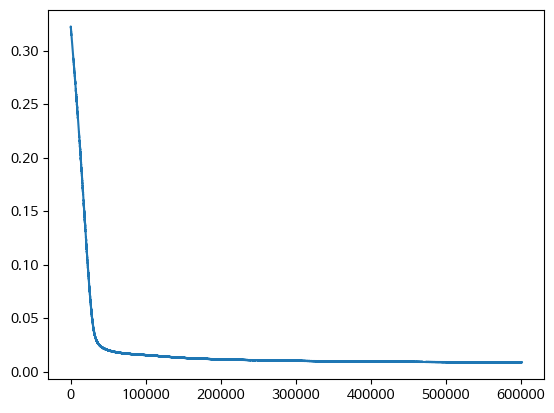

In [ ]:
plt.plot(loss_list)

# Validation

In [16]:
# torch.save(model.state_dict(), 'result/lstm_selection_parameters.pth')
model.load_state_dict(torch.load('result/lstm_selection_parameters.pth'))

<All keys matched successfully>

In [17]:
df_x_ss = ss.transform(X)
df_y_ms = ms.transform(y)

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

In [18]:
df_x_ss = df_x_ss.to(device)

train_predict = model(df_x_ss)


predicted = train_predict.cpu().data.numpy()
label_y = df_y_ms.data.numpy()
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

In [19]:
print(label_y.shape, predicted.shape)

(30475, 9) (30475, 9)


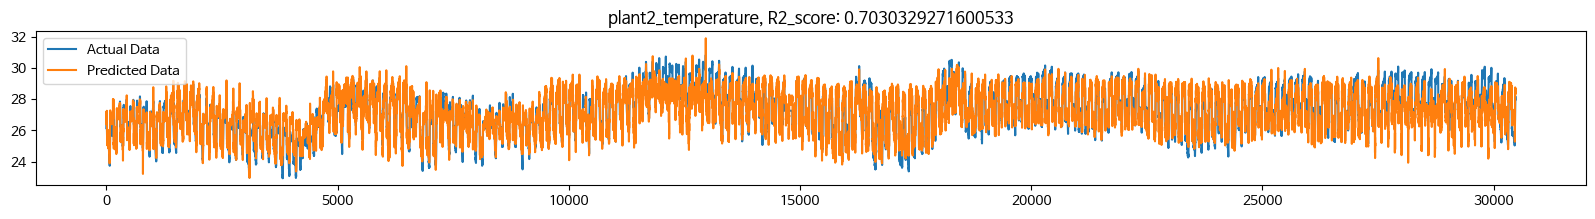

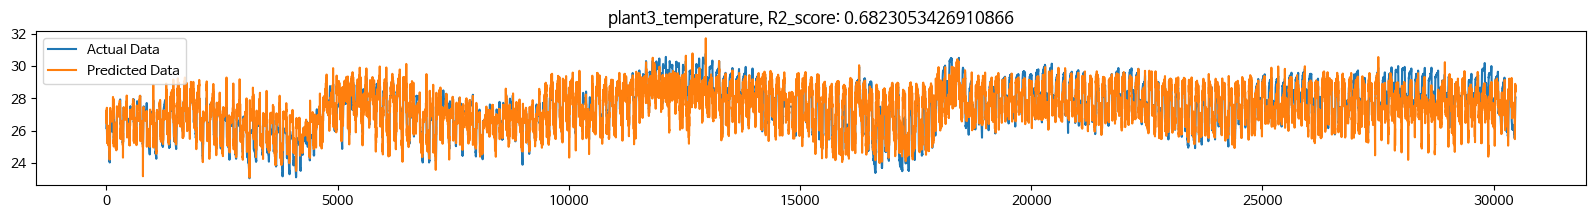

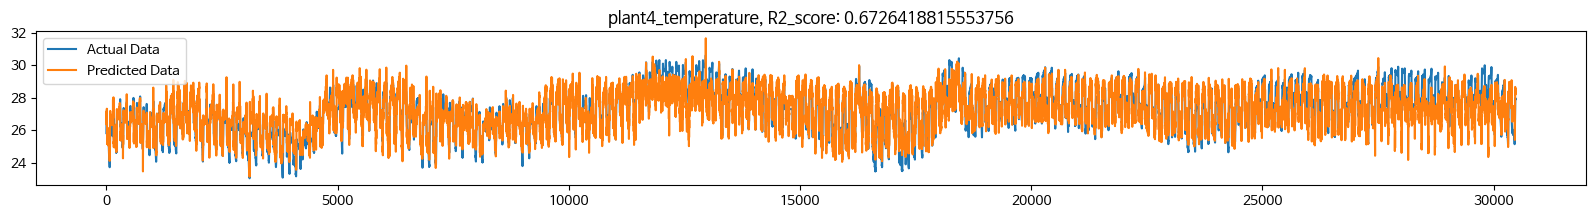

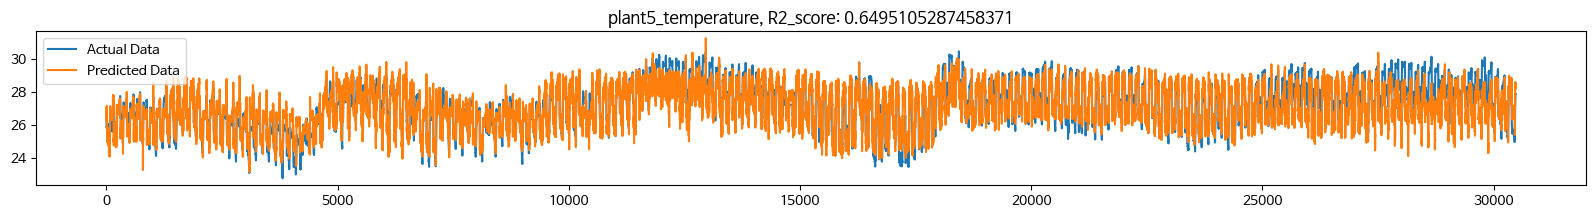

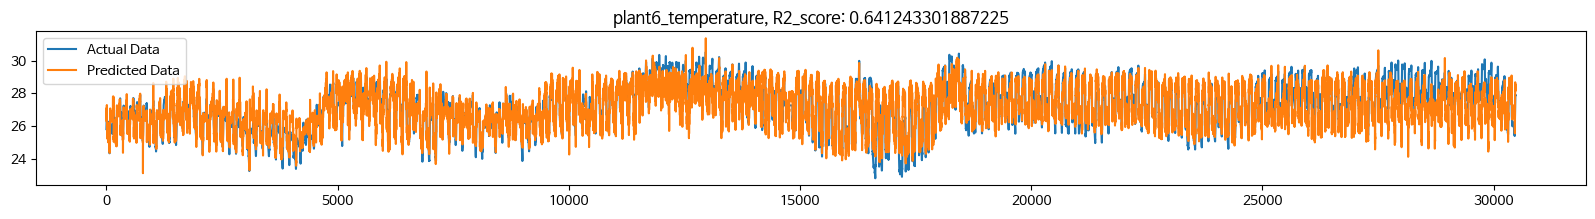

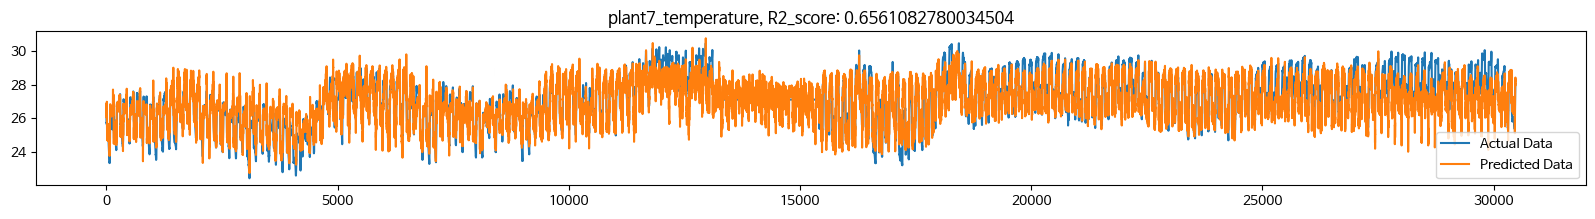

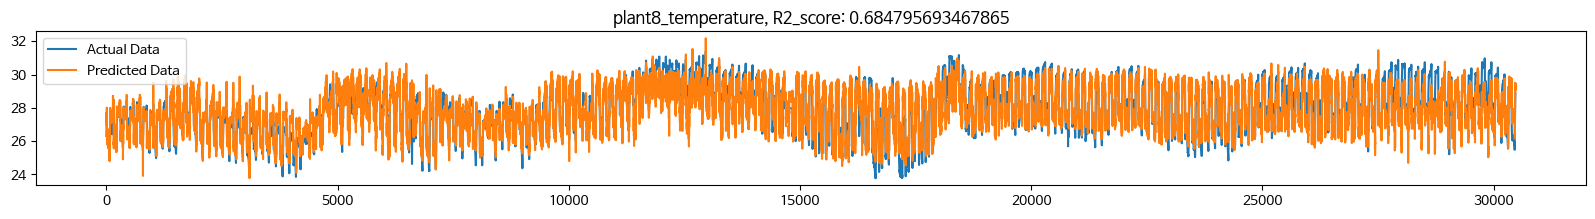

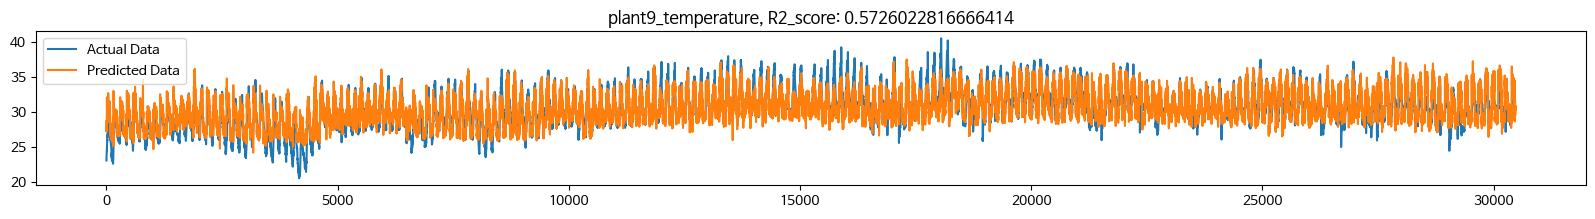

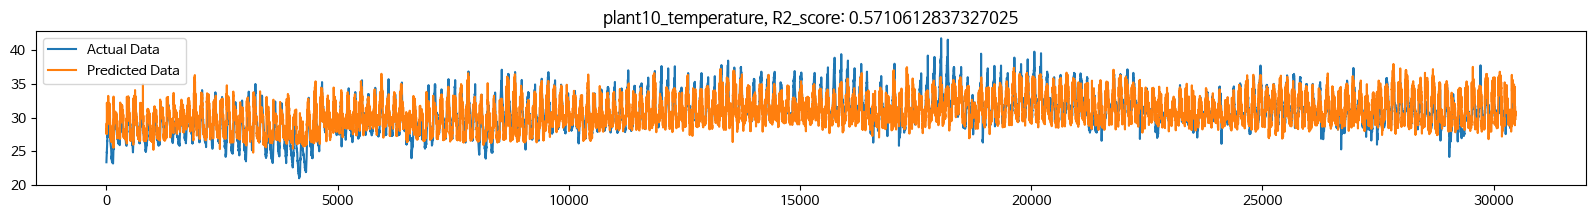

In [20]:
# plt.axvline(x=200, c='r', linestyle='--')

for i in range(9):
  plt.figure(figsize=(20,2))
  plt.plot(label_y[:,i], label='Actual Data')
  plt.plot(predicted[:,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(label_y[:,i], predicted[:,i])}')
  plt.legend()
  plt.show()

In [ ]:
df_train.iloc[len_train:]

ahu1_inv  ahu2_inv  ahu3_inv  ahu4_inv  ahu5_inv  \
cdate                                                                   
2023-06-19 15:20:00      45.0      35.0      45.0      45.0      40.0   
2023-06-19 15:30:00      45.0      35.0      45.0      45.0      40.0   
2023-06-19 15:40:00      45.0      35.0      45.0      45.0      40.0   
2023-06-19 15:50:00      45.0      35.0      45.0      45.0      40.0   
2023-06-19 16:00:00      45.0      35.0      45.0      45.0      40.0   
...                       ...       ...       ...       ...       ...   
2023-07-31 22:20:00       0.0       0.0       0.0       0.0       0.0   
2023-07-31 22:30:00       0.0       0.0       0.0       0.0       0.0   
2023-07-31 22:40:00       0.0       0.0       0.0       0.0       0.0   
2023-07-31 22:50:00       0.0       0.0       0.0       0.0       0.0   
2023-07-31 23:00:00       0.0       0.0       0.0       0.0       0.0   

                     ahu7_inv  ahu8_inv  ahu9_inv  ahu10_inv  ahu11_inv  ...  \
cdate                                                                    ...   
2023-06-19 15:20:00      45.0      45.0      45.0       45.0       45.0  ...   
2023-06-19 15:30:00      45.0      45.0      45.0       45.0       45.0  ...   
2023-06-19 15:40:00      45.0      45.0      45.0       45.0       45.0  ...   
2023-06-19 15:50:00      45.0      45.0      45.0       45.0       45.0  ...   
2023-06-19 16:00:00      45.0      45.0      45.0       45.0       45.0  ...   
...                       ...       ...       ...        ...        ...  ...   
2023-07-31 22:20:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-07-31 22:30:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-07-31 22:40:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-07-31 22:50:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-07-31 23:00:00       0.0       0.0       0.0        0.0        0.0  ...   

                     plant5_temperature  plant6_temperature  \
cdate                                                         
2023-06-19 15:20:00               25.96               25.94   
2023-06-19 15:30:00               25.95               25.98   
2023-06-19 15:40:00               25.95               25.98   
2023-06-19 15:50:00               25.92               26.03   
2023-06-19 16:00:00               25.92               25.98   
...                                 ...                 ...   
2023-07-31 22:20:00               27.87               27.87   
2023-07-31 22:30:00               27.87               27.90   
2023-07-31 22:40:00               27.87               27.87   
2023-07-31 22:50:00               27.90               27.86   
2023-07-31 23:00:00               27.87               27.89   

                     plant7_temperature  plant7_humidity  plant8_temperature  \
cdate                                                                          
2023-06-19 15:20:00               26.25            37.69               26.52   
2023-06-19 15:30:00               26.22            37.80               26.49   
2023-06-19 15:40:00               26.21            37.92               26.51   
2023-06-19 15:50:00               26.27            37.96               26.58   
2023-06-19 16:00:00               26.27            37.98               26.52   
...                                 ...              ...                 ...   
2023-07-31 22:20:00               28.05            40.38               28.79   
2023-07-31 22:30:00               28.05            40.60               28.80   
2023-07-31 22:40:00               28.04            40.82               28.83   
2023-07-31 22:50:00               28.04            41.17               28.84   
2023-07-31 23:00:00               28.05            41.15               28.87   

                     plant10_temperature  ahu13_inv  plant4_humidity  \
cdate                                                                  
2023-06-19 15:20:00      

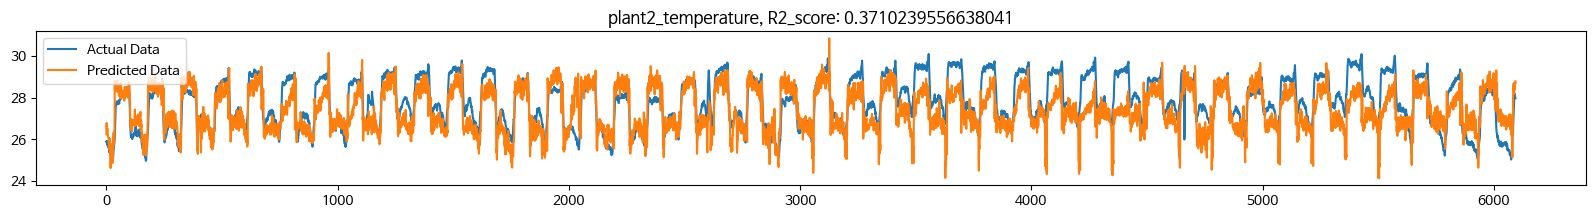

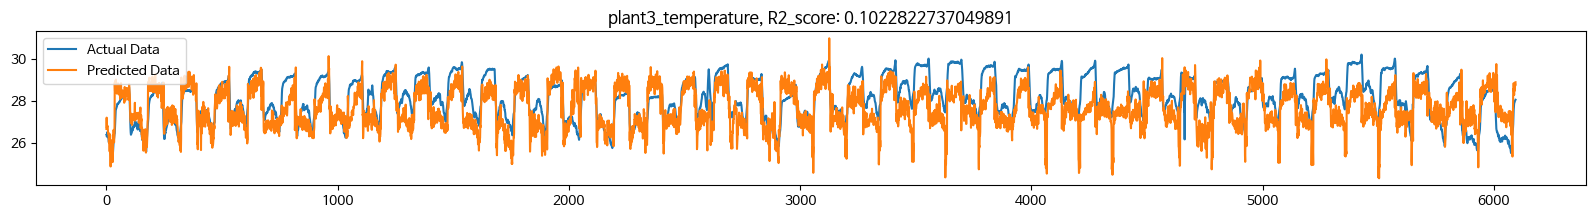

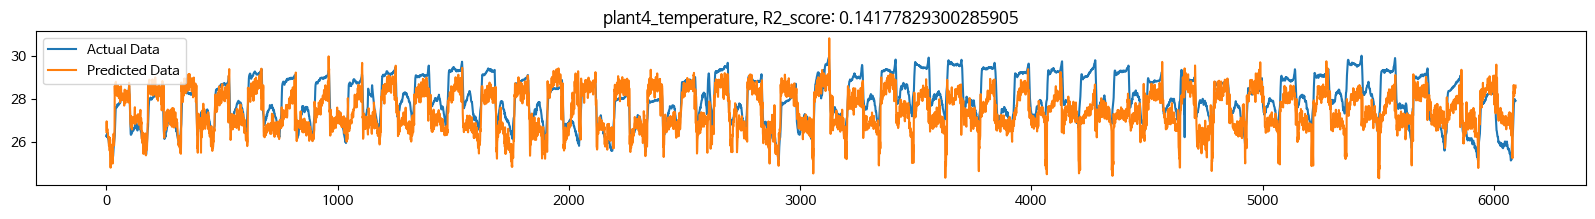

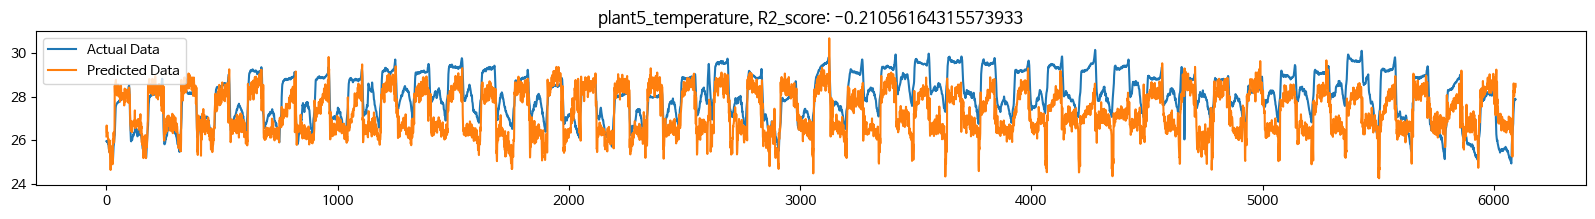

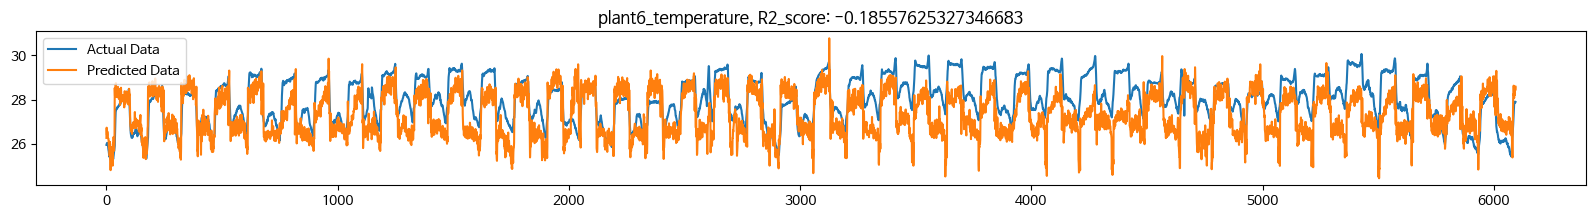

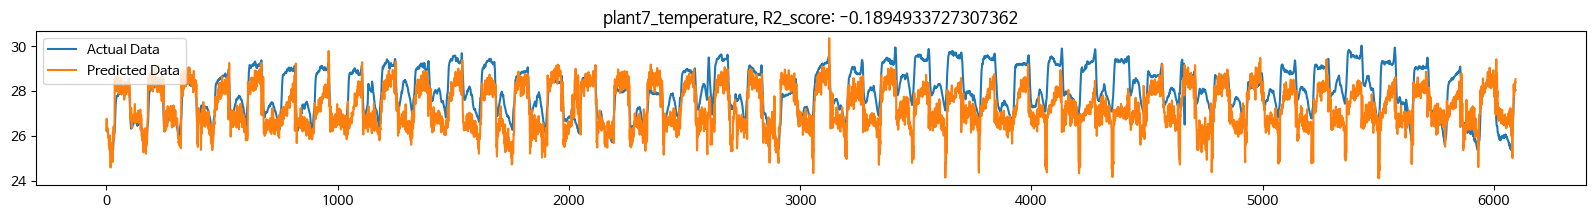

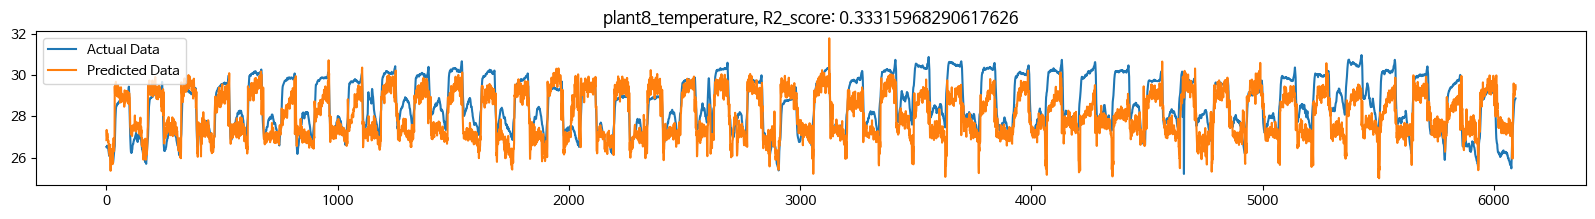

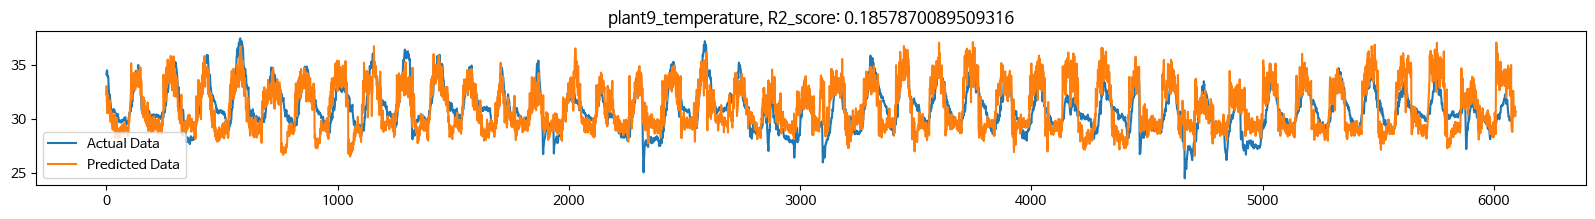

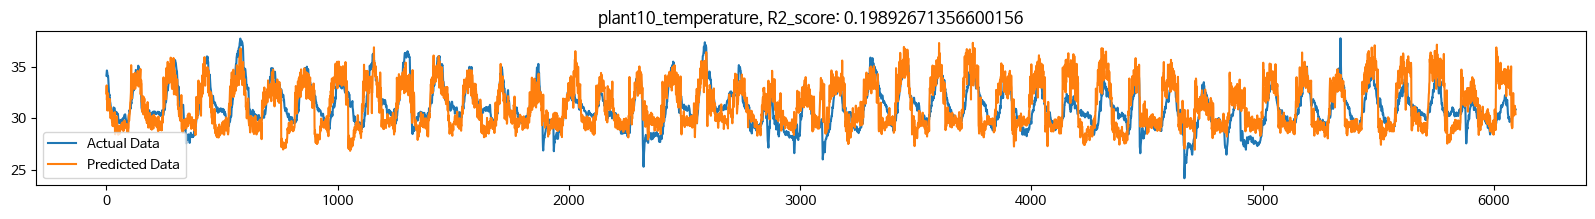

In [ ]:
# plt.axvline(x=200, c='r', linestyle='--')

valid_y = label_y[len_train:,:]
gt_y = predicted[len_train: , :]


for i in range(9):
  plt.figure(figsize=(20,2))
  plt.plot(valid_y [:,i], label='Actual Data')
  plt.plot(gt_y[:,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(valid_y[:,i], gt_y[:,i])}')
  plt.legend()
  plt.show()

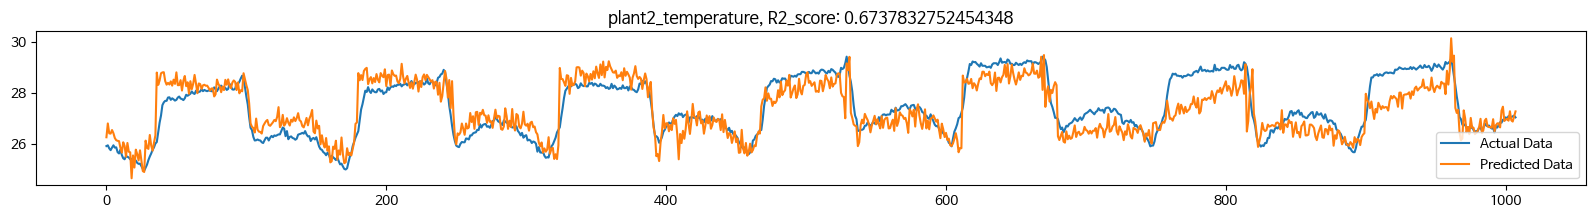

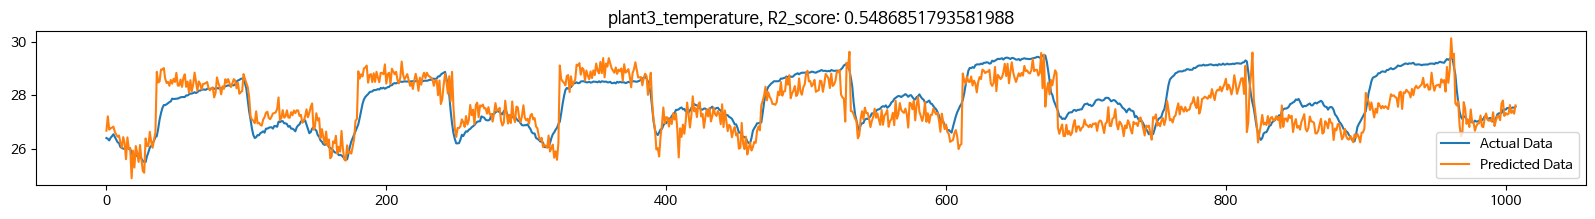

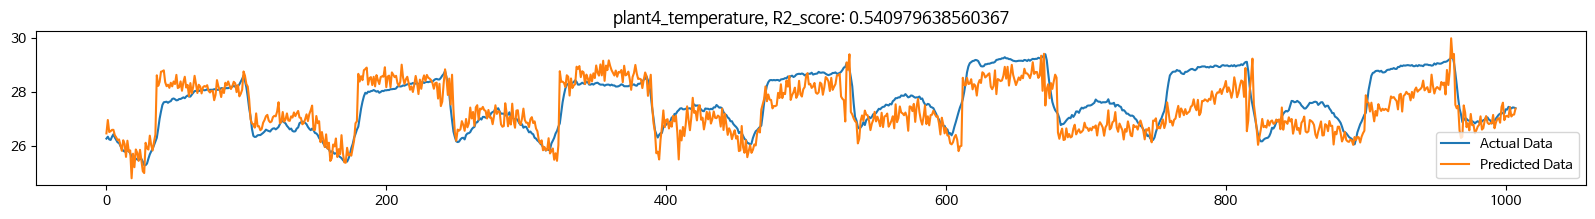

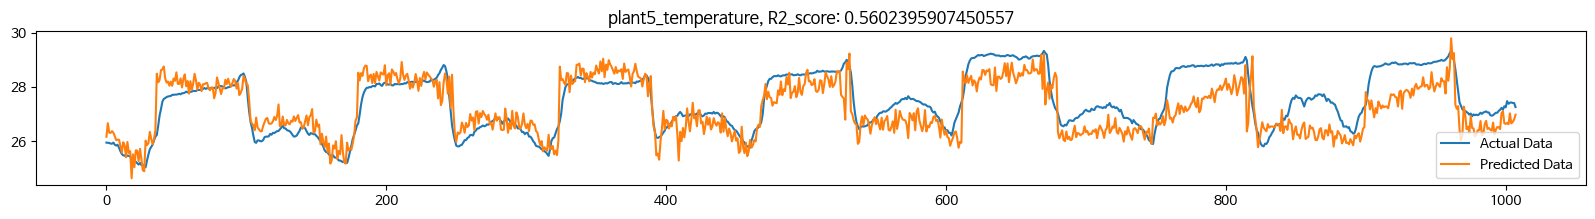

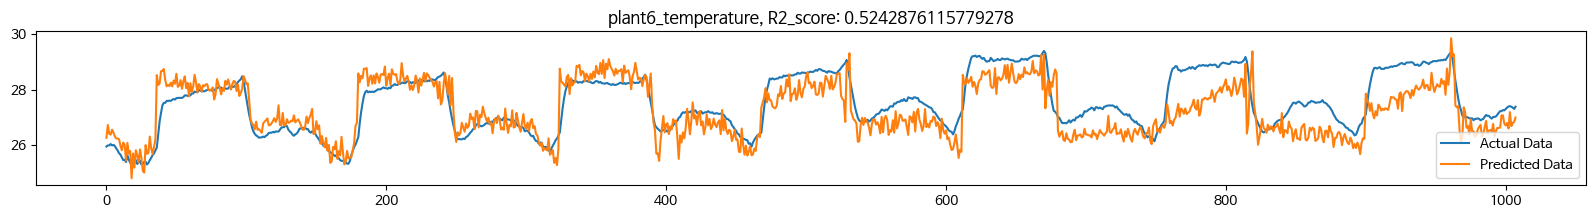

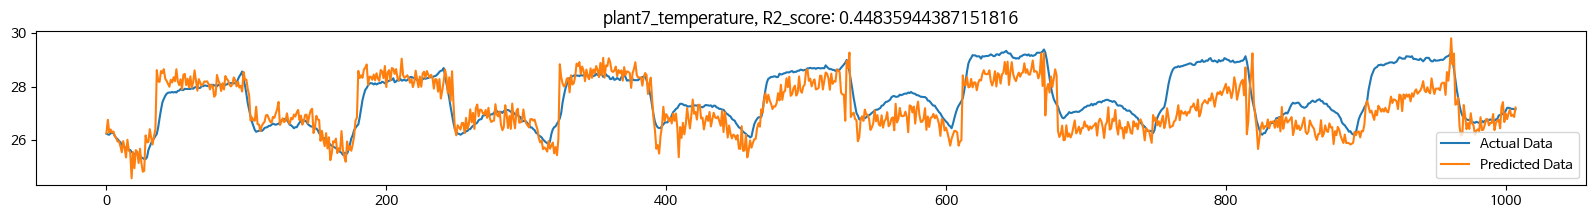

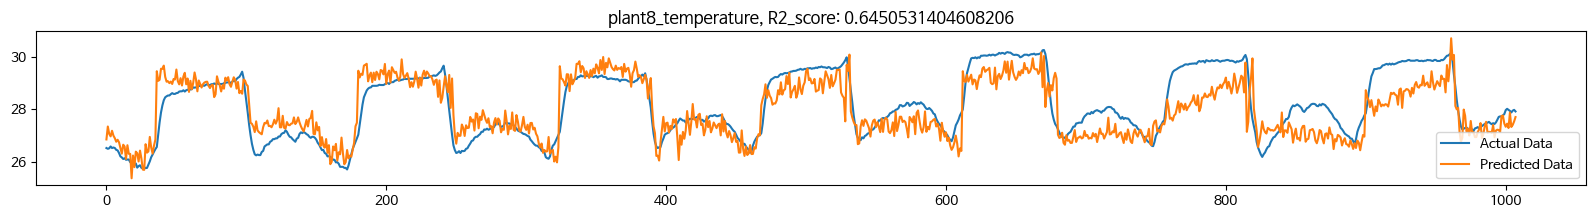

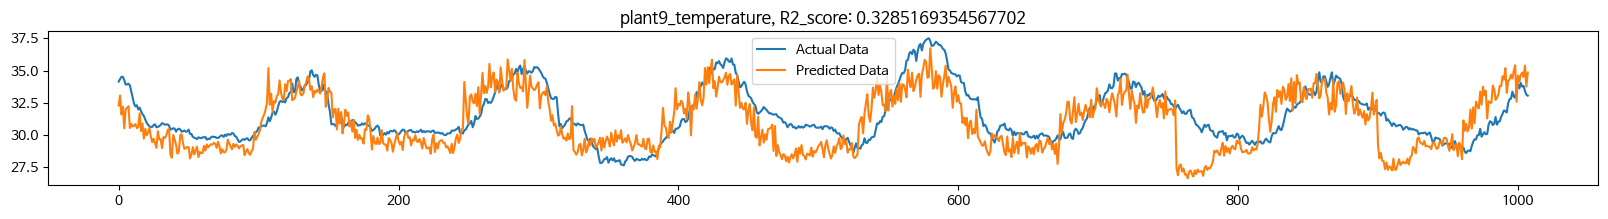

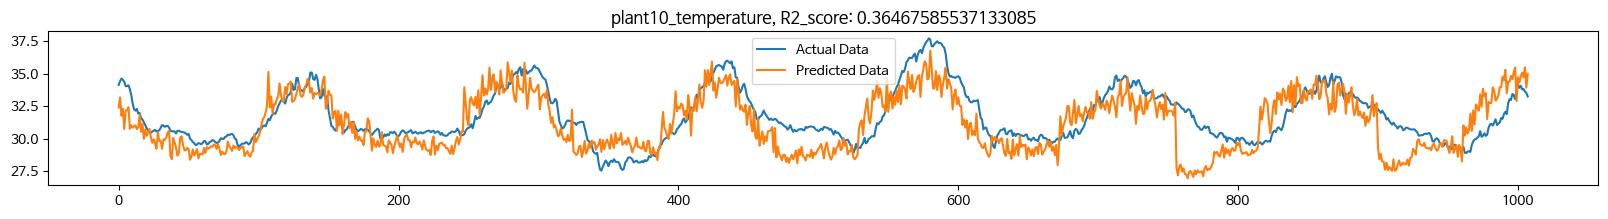

In [ ]:
# plt.axvline(x=200, c='r', linestyle='--')

valid_y = label_y[len_train:,:]
gt_y = predicted[len_train: , :]


for i in range(9):
  plt.figure(figsize=(20,2))
  plt.plot(valid_y [:6*24*7,i], label='Actual Data')
  plt.plot(gt_y[:6*24*7,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(valid_y[:6*24*7:,i], gt_y[:6*24*7,i])}')
  plt.legend()
  plt.show()

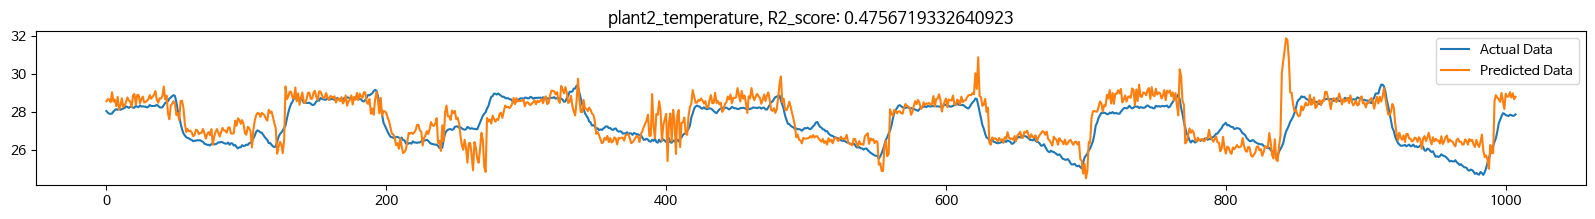

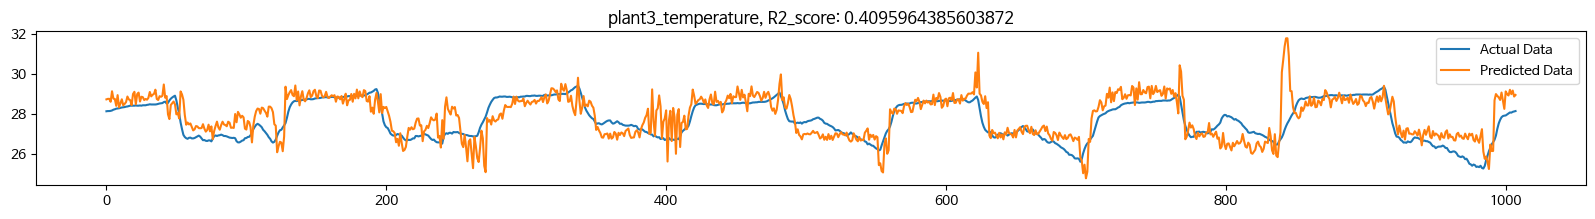

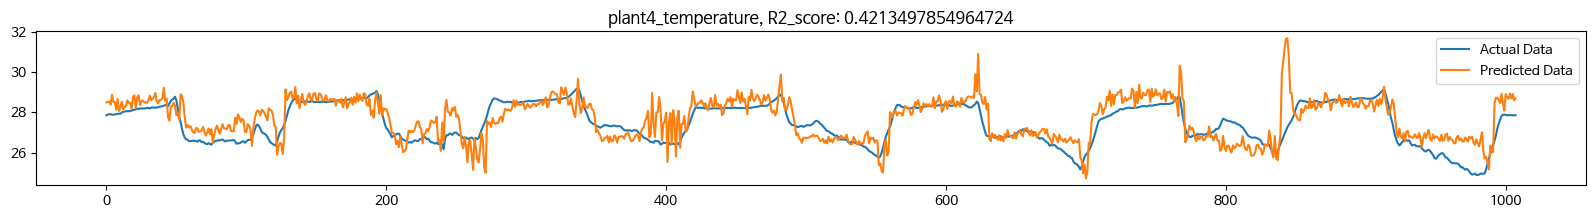

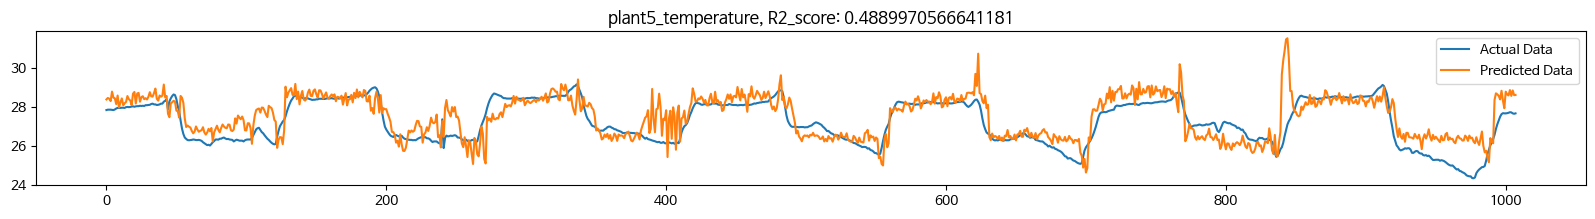

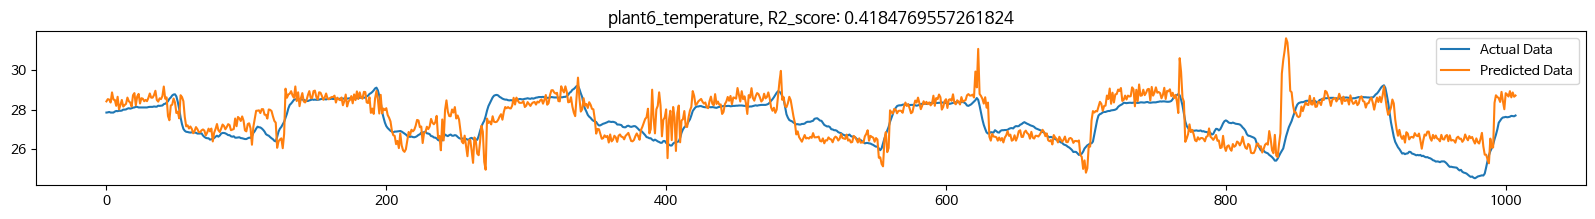

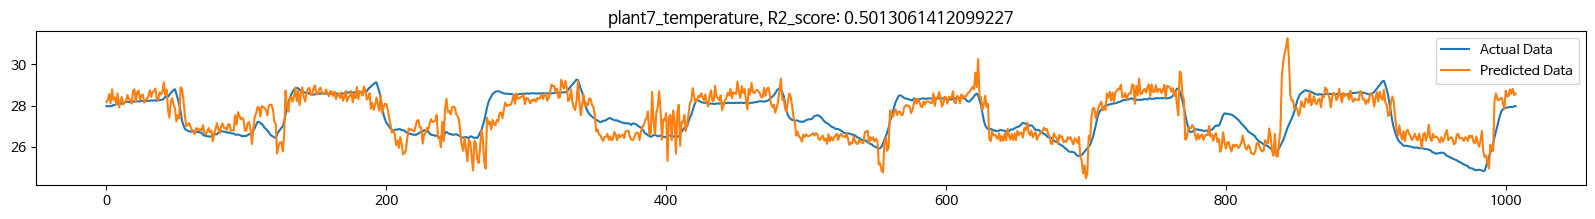

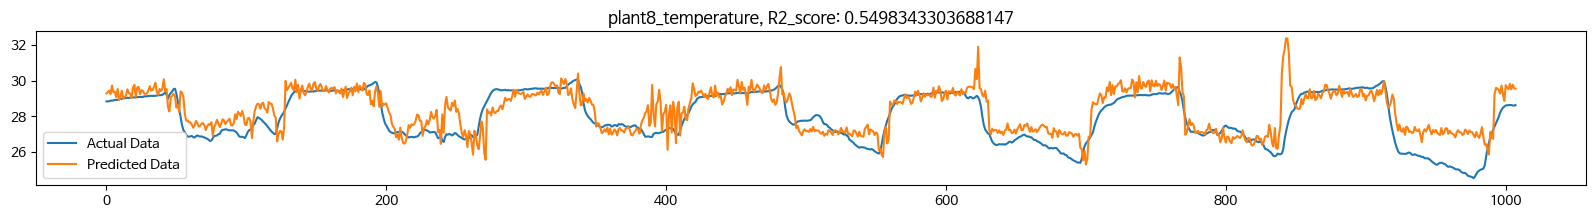

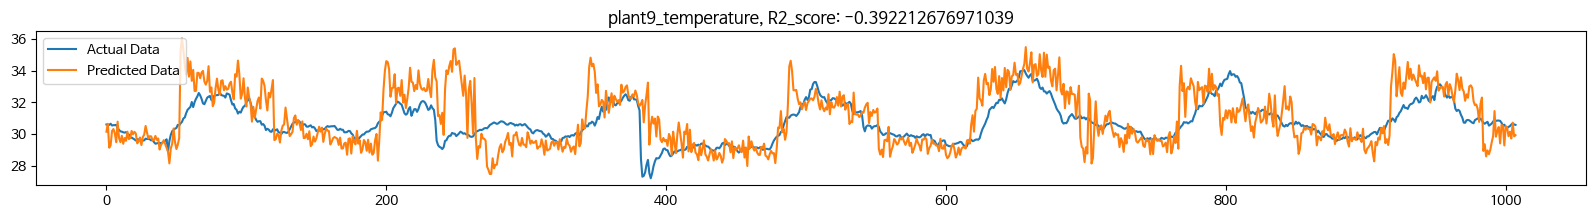

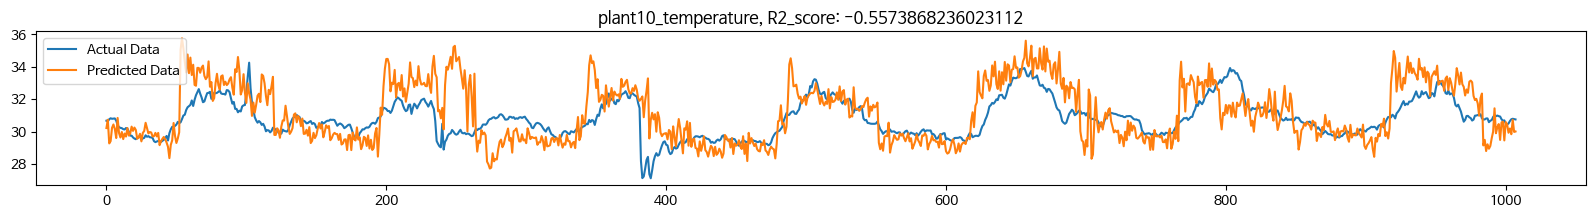

In [ ]:
# plt.axvline(x=200, c='r', linestyle='--')

valid_y = label_y[len_train:,:]
gt_y = predicted[len_train: , :]


for i in range(9):
  plt.figure(figsize=(20,2))
  plt.plot(label_y[:6*24*7,i], label='Actual Data')
  plt.plot(predicted[:6*24*7,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(label_y[:6*24*7:,i], predicted[:6*24*7,i])}')
  plt.legend()
  plt.show()

# test

In [ ]:
df_test

ahu1_inv  ahu2_inv  ahu3_inv  ahu4_inv  ahu5_inv  \
cdate                                                                   
2023-08-01 00:00:00         0         0         0         0         0   
2023-08-01 00:10:00         0         0         0         0         0   
2023-08-01 00:20:00         0         0         0         0         0   
2023-08-01 00:30:00         0         0         0         0         0   
2023-08-01 00:40:00         0         0         0         0         0   
...                       ...       ...       ...       ...       ...   
2023-09-30 23:10:00         0         0         0         0         0   
2023-09-30 23:20:00         0         0         0         0         0   
2023-09-30 23:30:00         0         0         0         0         0   
2023-09-30 23:40:00         0         0         0         0         0   
2023-09-30 23:50:00         0         0         0         0         0   

                     ahu7_inv  ahu8_inv  ahu9_inv  ahu10_inv  ahu11_inv  ...  \
cdate                                                                    ...   
2023-08-01 00:00:00         0         0         0          0          0  ...   
2023-08-01 00:10:00         0         0         0          0          0  ...   
2023-08-01 00:20:00         0         0         0          0          0  ...   
2023-08-01 00:30:00         0         0         0          0          0  ...   
2023-08-01 00:40:00         0         0         0          0          0  ...   
...                       ...       ...       ...        ...        ...  ...   
2023-09-30 23:10:00         0         0         0          0          0  ...   
2023-09-30 23:20:00         0         0         0          0          0  ...   
2023-09-30 23:30:00         0         0         0          0          0  ...   
2023-09-30 23:40:00         0         0         0          0          0  ...   
2023-09-30 23:50:00         0         0         0          0          0  ...   

                     plant5_temperature  plant6_temperature  \
cdate                                                         
2023-08-01 00:00:00               27.85               27.85   
2023-08-01 00:10:00               27.87               27.86   
2023-08-01 00:20:00               27.87               27.88   
2023-08-01 00:30:00               27.87               27.85   
2023-08-01 00:40:00               27.86               27.85   
...                                 ...                 ...   
2023-09-30 23:10:00               28.04               27.74   
2023-09-30 23:20:00               28.04               27.74   
2023-09-30 23:30:00               28.03               27.76   
2023-09-30 23:40:00               28.01               27.76   
2023-09-30 23:50:00               28.01               27.74   

                     plant7_temperature  plant7_humidity  plant8_temperature  \
cdate                                                                          
2023-08-01 00:00:00               27.98            41.65               28.85   
2023-08-01 00:10:00               27.98            41.77               28.85   
2023-08-01 00:20:00               27.98            41.85               28.86   
2023-08-01 00:30:00               27.98            41.96               28.89   
2023-08-01 00:40:00               27.98            41.94               28.89   
...                                 ...              ...                 ...   
2023-09-30 23:10:00               27.81            46.15               28.87   
2023-09-30 23:20:00               27.81            46.15               28.85   
2023-09-30 23:30:00               27.81            46.18               28.83   
2023-09-30 23:40:00               27.80            46.22               28.81   
2023-09-30 23:50:00               27.80            46.27               28.83   

                     plant10_temperature  ahu13_inv  plant4_humidity  \
cdate                                                                  
2023-08-01 00:00:00      

In [21]:
yt = df_test.loc[:,target]
Xt = df_test.drop(columns=target)

df_x_ss = ss.transform(Xt)
df_y_ms = ms.transform(yt)

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

df_x_ss = df_x_ss.to(device)

train_predict = model(df_x_ss)


predicted = train_predict.cpu().data.numpy()
label_y = df_y_ms.data.numpy()
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

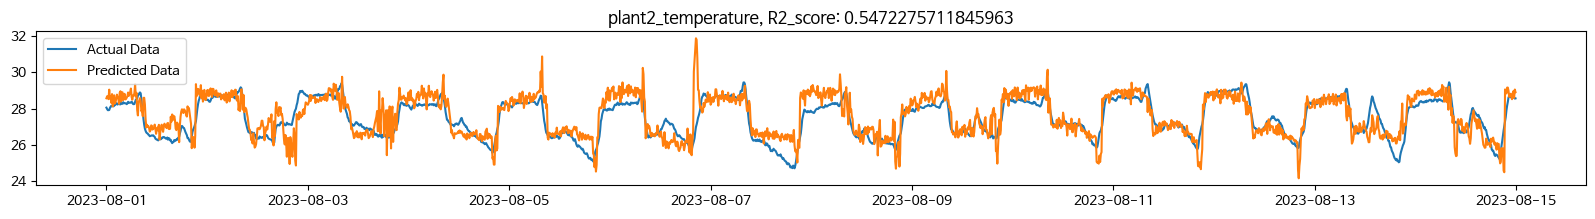

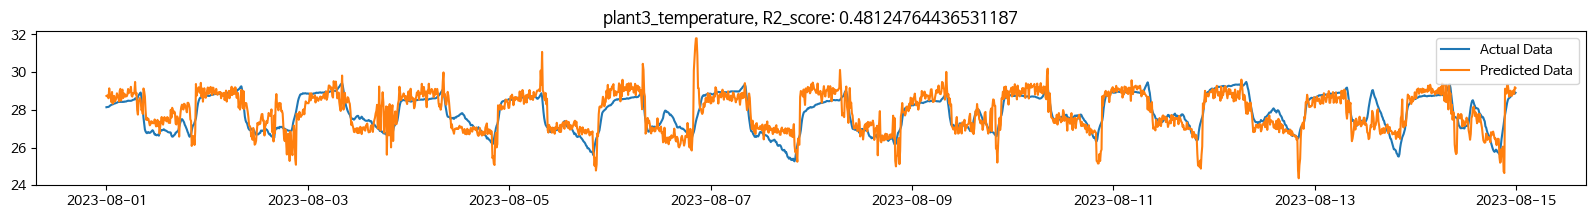

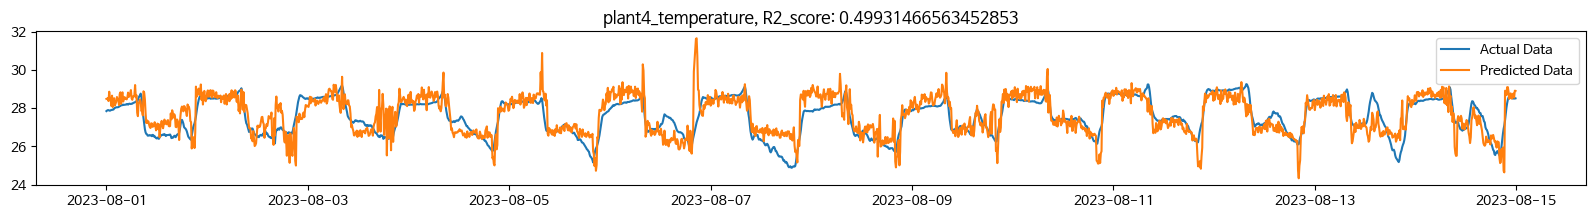

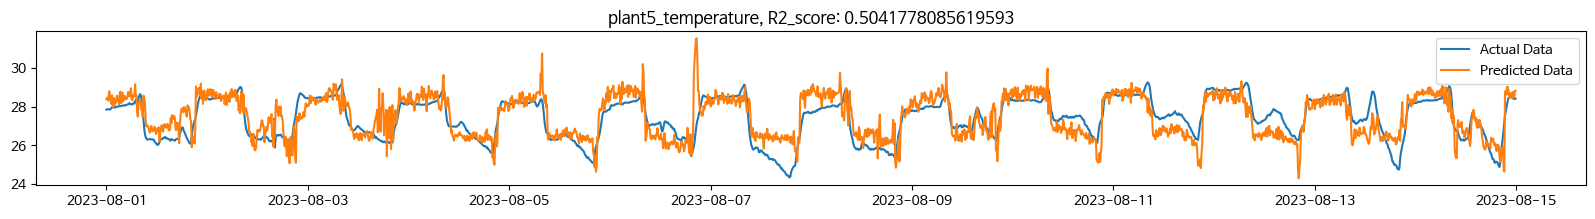

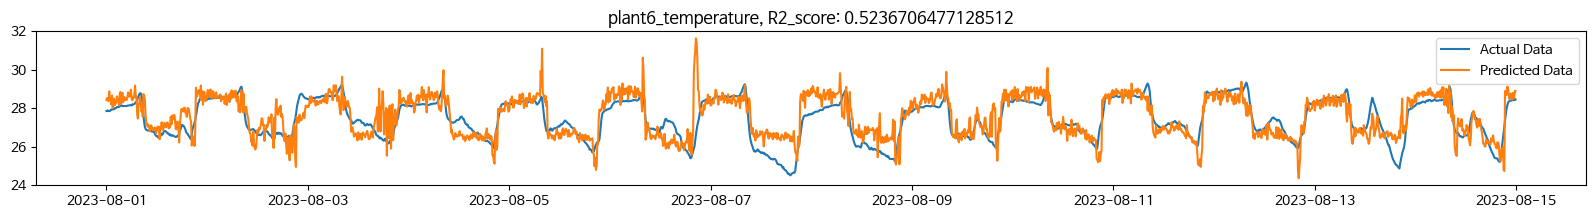

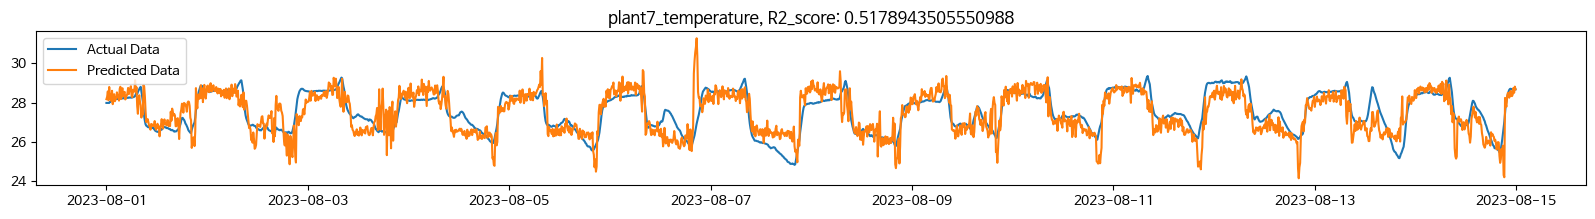

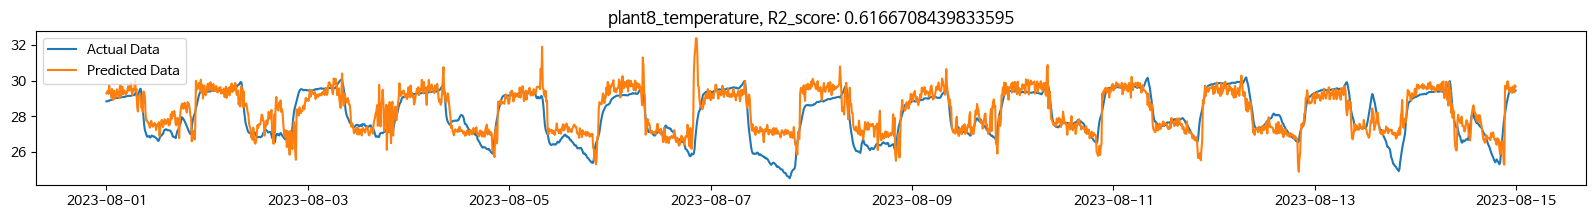

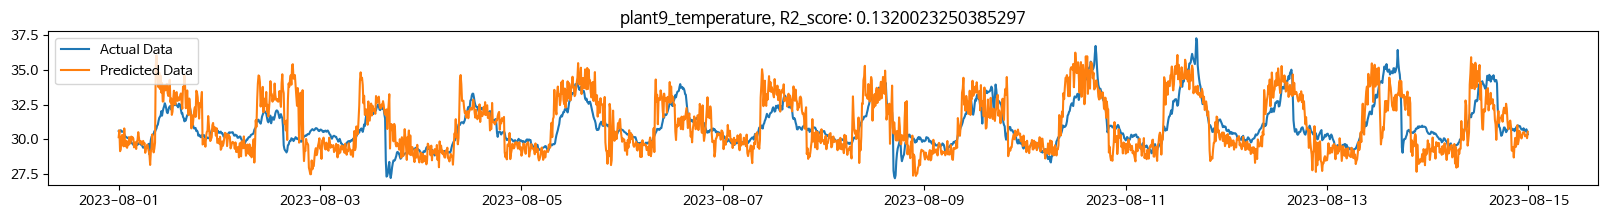

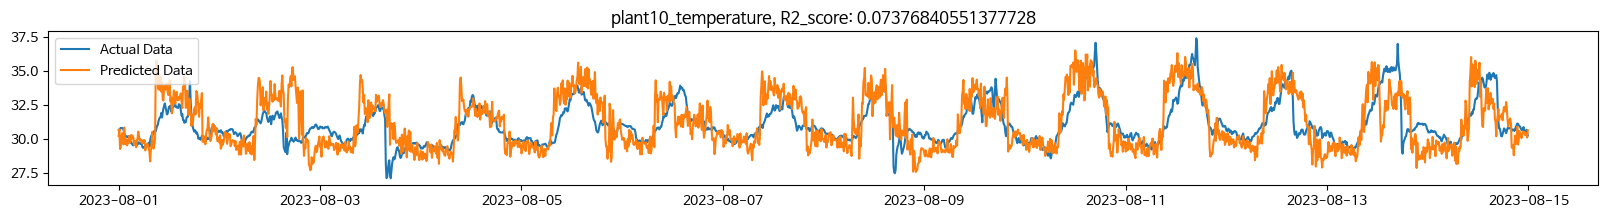

In [ ]:
# plt.axvline(x=200, c='r', linestyle='--')
week2 = 2*7*24*6
start_date = "2023-08-01 00:00:00"
end_date = "2023-08-14 23:50:00"
date_range = pd.date_range(start=start_date, end=end_date, freq='10T')


for i in range(9):
  plt.figure(figsize=(20,2))
  plt.plot(date_range, label_y[:week2,i], label='Actual Data')
  plt.plot(date_range, predicted[:week2,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(label_y[:week2,i], predicted[:week2,i])}')
  plt.legend()
  plt.show()

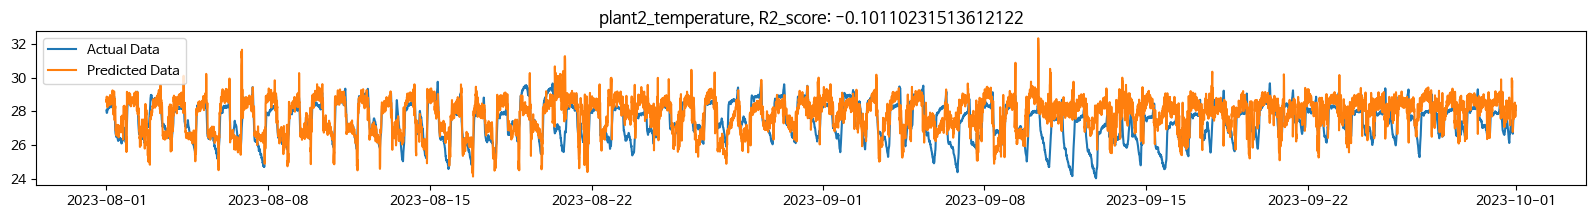

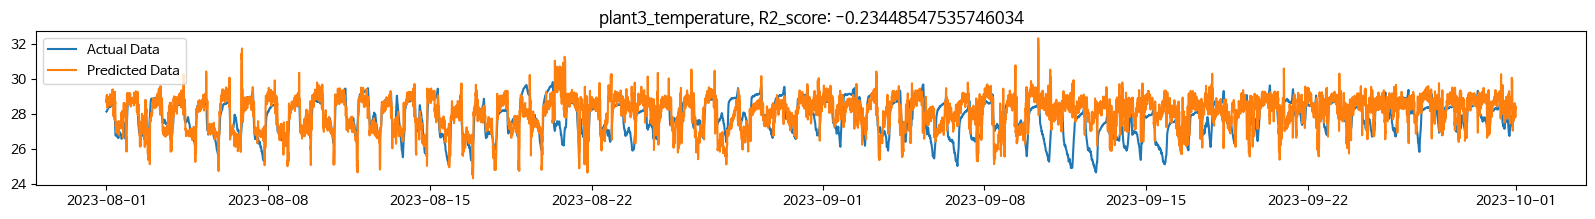

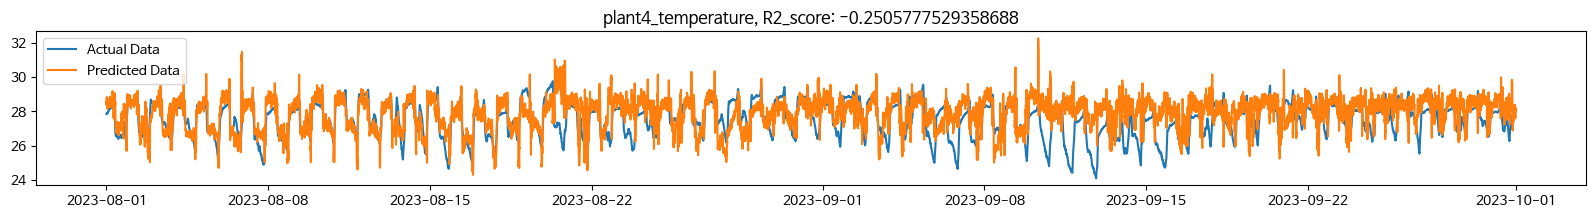

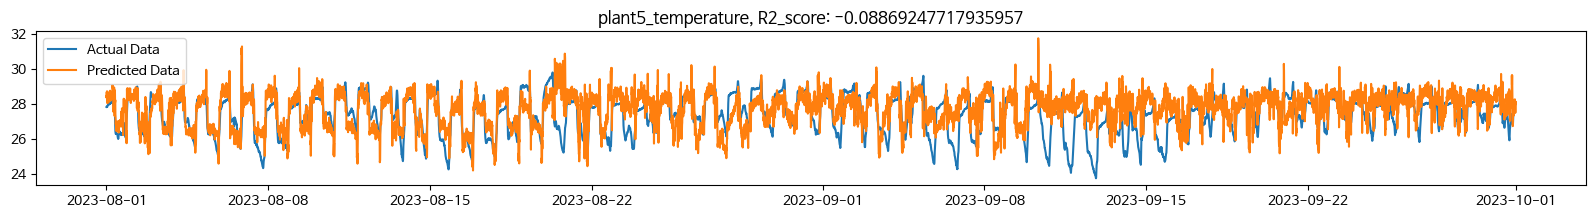

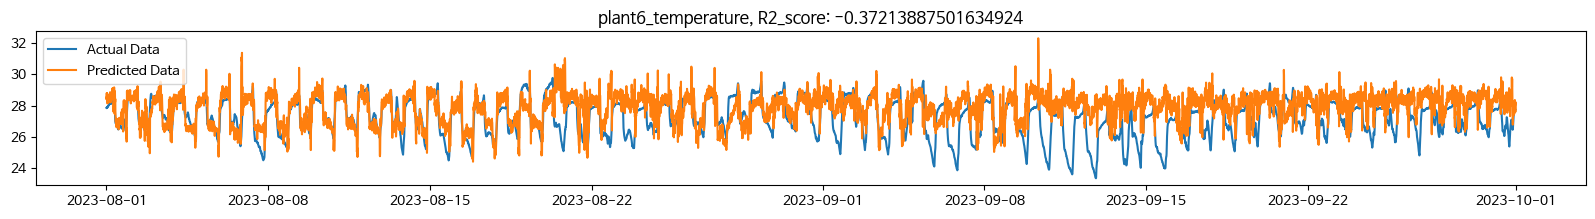

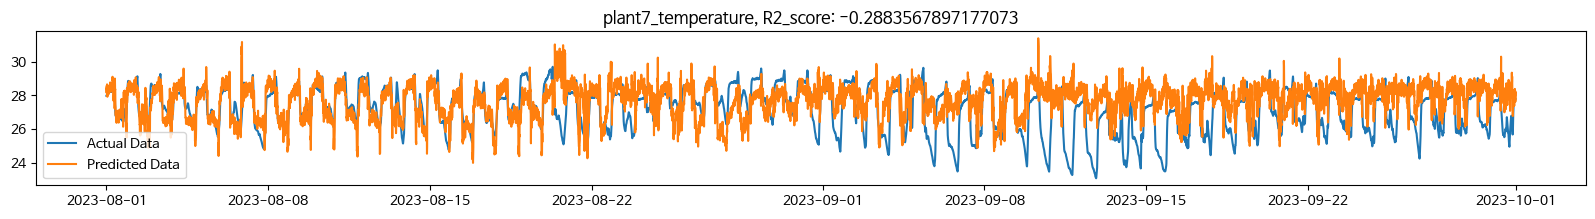

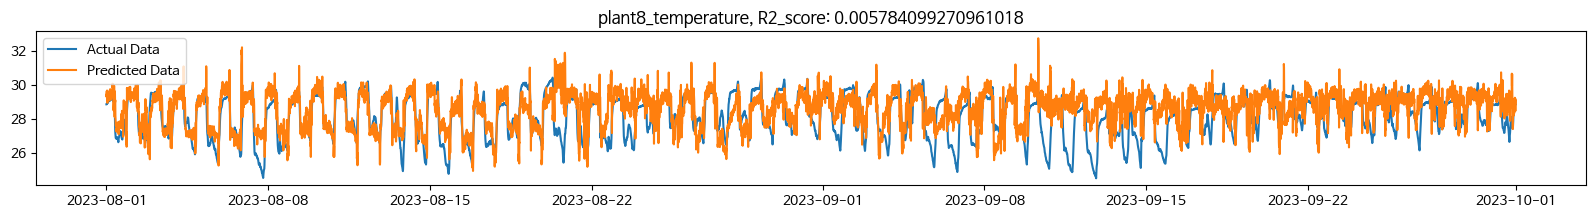

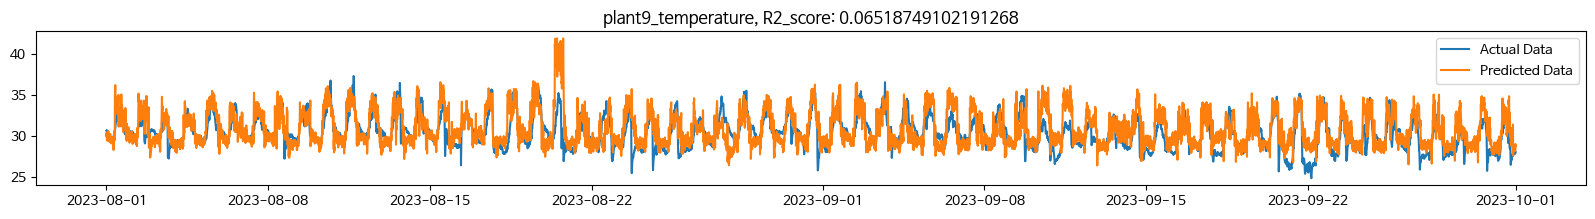

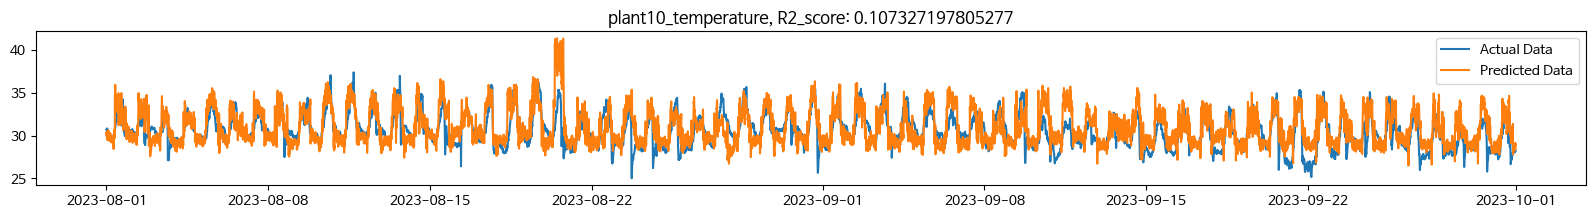

In [24]:
# plt.axvline(x=200, c='r', linestyle='--')
# week2 = 2*7*24*6
start_date = "2023-08-01 00:00:00"
end_date = "2023-09-30 23:50:00"
date_range = pd.date_range(start=start_date, end=end_date, freq='10T')


for i in range(9):
  plt.figure(figsize=(20,2))
  plt.plot(date_range, label_y[:,i], label='Actual Data')
  plt.plot(date_range, predicted[:,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(label_y[:,i], predicted[:,i])}')
  plt.legend()
  plt.show()

In [25]:
result = pd.DataFrame(columns=[f'plant{i+1}_temperature' for i in range(1,9)], index=pd.date_range(start=start_date, end=end_date, freq='10T'))
for i in range(9):
    result[f'plant{i+1}_temperature'] = label_y[:,i]

In [30]:
result.to_csv('result/temp_result.csv')